# Aim : To build a classification model which can effectively and accurately predict whether a given bank customer will default on his/her credit or not.

In [1]:
import pandas as pd
import numpy as np
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import xgboost
import lightgbm as lgbm
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import ExtraTreesClassifier,HistGradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB

from random import sample
from scipy.stats import boxcox, skew, norm, kurtosis
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

C:\Users\Munj Patel\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sns.set_style(style = 'darkgrid')
plt.rcParams['figure.figsize'] = 10,10
warnings.filterwarnings('ignore')

In [3]:
na_l = ['na','NA','nan','NaN','NAN','?','--','']

df = pd.read_csv(r"C:\Users\Munj Patel\Desktop\CSE-5007_J_C\CSE5007_J_COMPONENT_FILE\UCI_Credit_Card.csv",na_values = na_l)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df = df.drop('ID', axis = 1)

In [5]:
df.rename(columns = {'default.payment.next.month' : 'default'}, inplace = True)

In [6]:
df.shape

(30000, 24)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [8]:
df.dtypes

LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
default        int64
dtype: object

In [9]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [10]:
for q in df.dtypes[df.dtypes == 'int64'].index:
    print(f'Number of distinct elements in {q} is {len(df[q].unique())}. They are: {sorted(df[q].unique())}\n')

Number of distinct elements in SEX is 2. They are: [1, 2]

Number of distinct elements in EDUCATION is 7. They are: [0, 1, 2, 3, 4, 5, 6]

Number of distinct elements in MARRIAGE is 4. They are: [0, 1, 2, 3]

Number of distinct elements in AGE is 56. They are: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79]

Number of distinct elements in PAY_0 is 11. They are: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Number of distinct elements in PAY_2 is 11. They are: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Number of distinct elements in PAY_3 is 11. They are: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Number of distinct elements in PAY_4 is 11. They are: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Number of distinct elements in PAY_5 is 10. They are: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]

Number of distinct elements in PAY_6 is 10. They are: [-2, -1

## EDA

## Finding and dropping the dupliacate values

In [11]:
df[df.duplicated() == True] # The duplicate records in the dataframe

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1980,150000.0,2,1,1,38,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4585,150000.0,2,1,1,31,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6022,210000.0,2,1,2,39,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6466,210000.0,2,2,1,49,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7319,500000.0,1,1,1,43,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8320,360000.0,1,2,1,41,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10250,50000.0,1,2,2,26,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13106,360000.0,2,1,1,49,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14294,20000.0,1,2,2,24,2,2,4,4,4,...,1650.0,1650.0,1650.0,0.0,0.0,0.0,0.0,0.0,0.0,1
15458,160000.0,1,2,2,28,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
df = df.drop_duplicates().reset_index(drop = True)
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29960,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29961,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29962,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29963,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


## Outlier Detection and Missing Value Treatment

The boxplot and distribution plot of LIMIT_BAL is as shown:


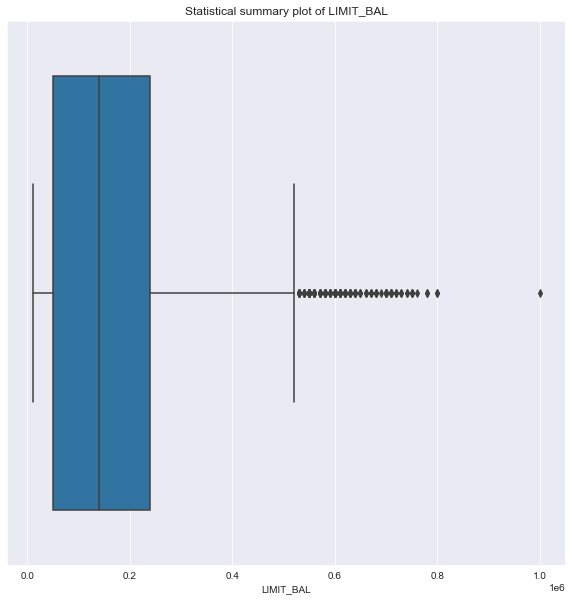

Skewness of LIMIT_BAL is 0.9934415939520723.
Kurtosis of LIMIT_BAL is 0.5372971964734372.


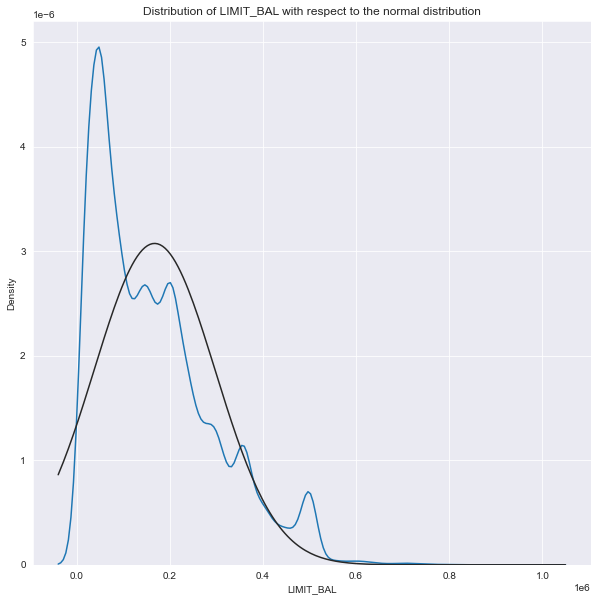



The boxplot and distribution plot of BILL_AMT1 is as shown:


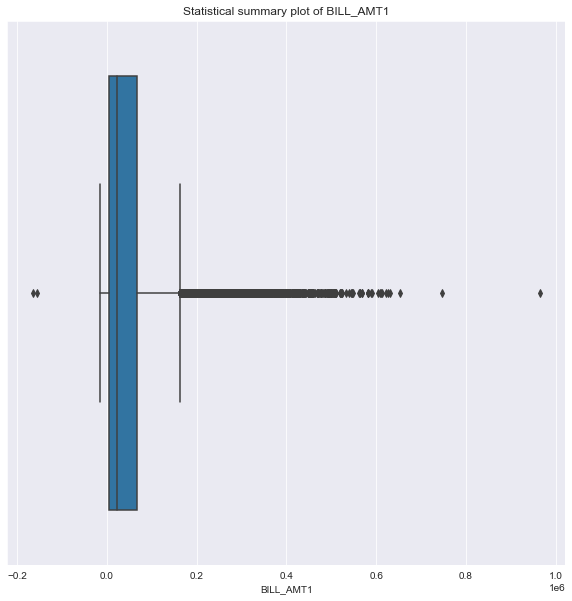

Skewness of BILL_AMT1 is 2.662380173326805.
Kurtosis of BILL_AMT1 is 9.795011353061389.


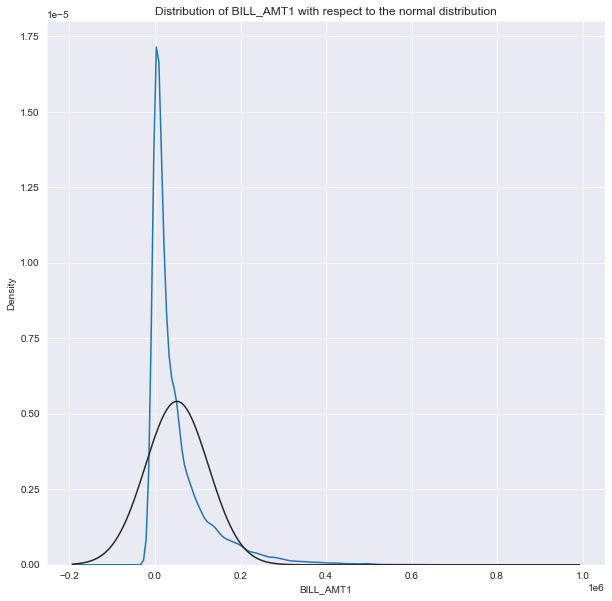



The boxplot and distribution plot of BILL_AMT2 is as shown:


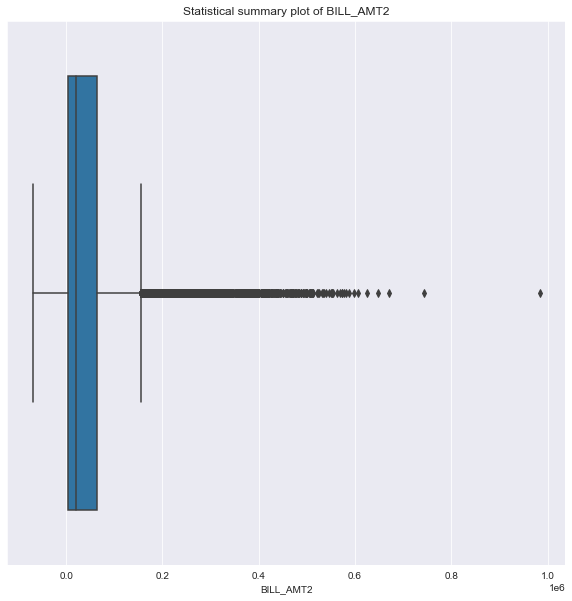

Skewness of BILL_AMT2 is 2.7037263870709416.
Kurtosis of BILL_AMT2 is 10.291294306046405.


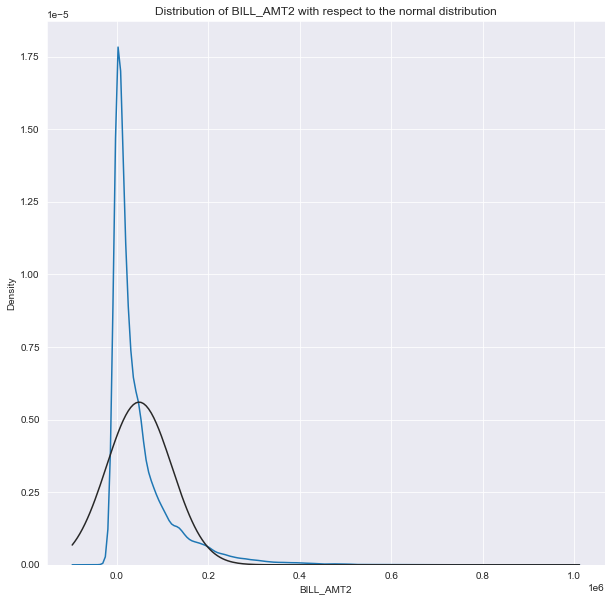



The boxplot and distribution plot of BILL_AMT3 is as shown:


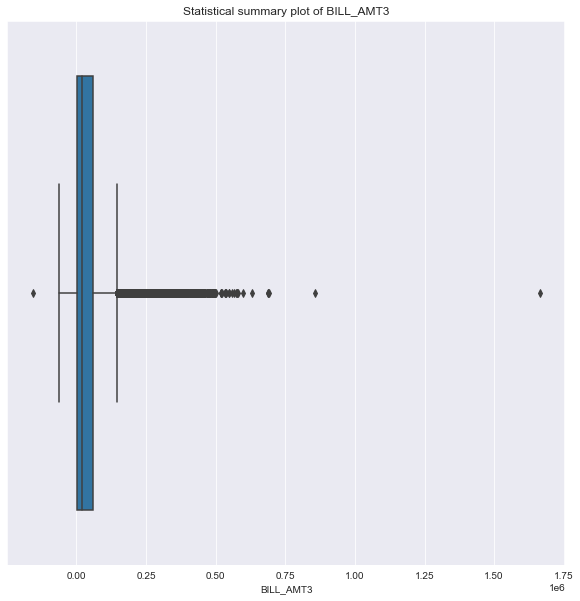

Skewness of BILL_AMT3 is 3.08633932483455.
Kurtosis of BILL_AMT3 is 19.767503472097907.


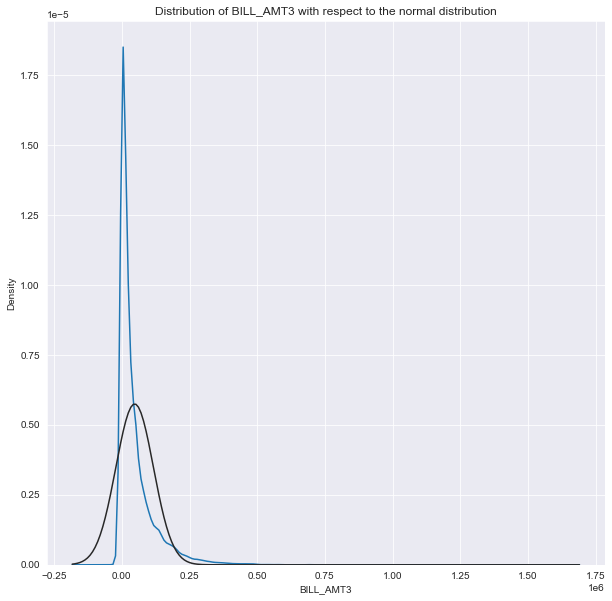



The boxplot and distribution plot of BILL_AMT4 is as shown:


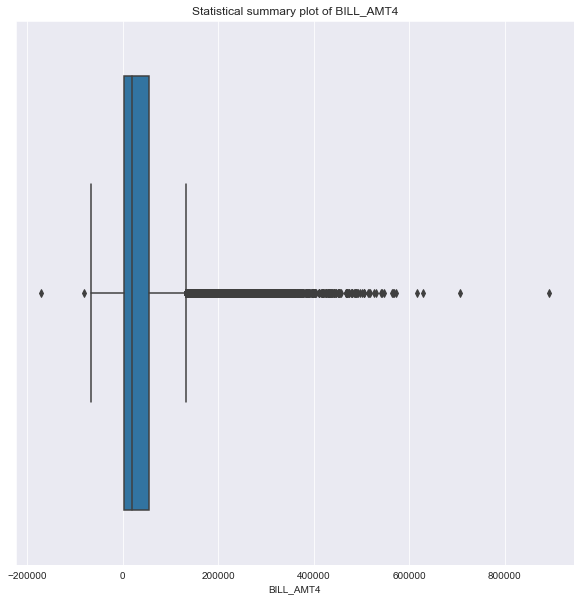

Skewness of BILL_AMT4 is 2.8204036376268142.
Kurtosis of BILL_AMT4 is 11.296496849983031.


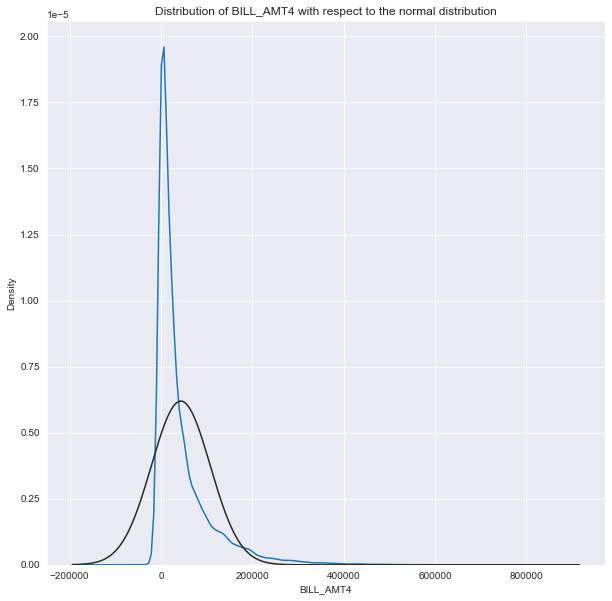



The boxplot and distribution plot of BILL_AMT5 is as shown:


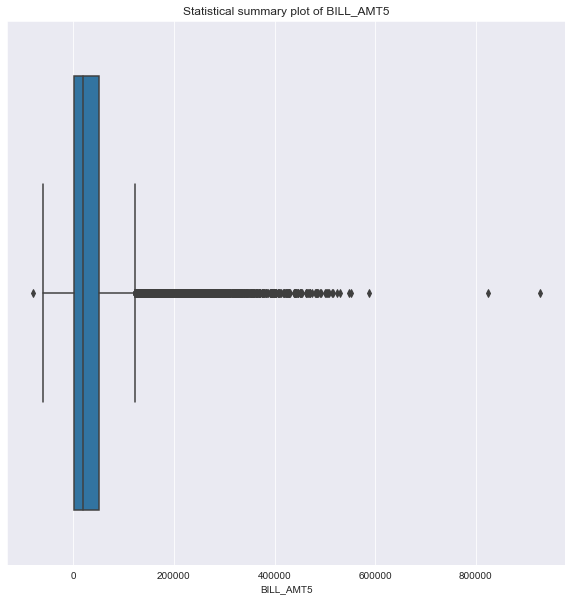

Skewness of BILL_AMT5 is 2.8747811333138555.
Kurtosis of BILL_AMT5 is 12.292287294329903.


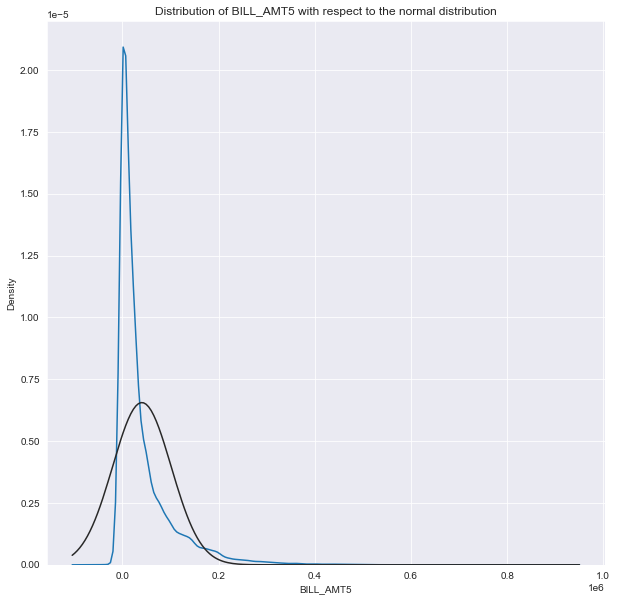



The boxplot and distribution plot of BILL_AMT6 is as shown:


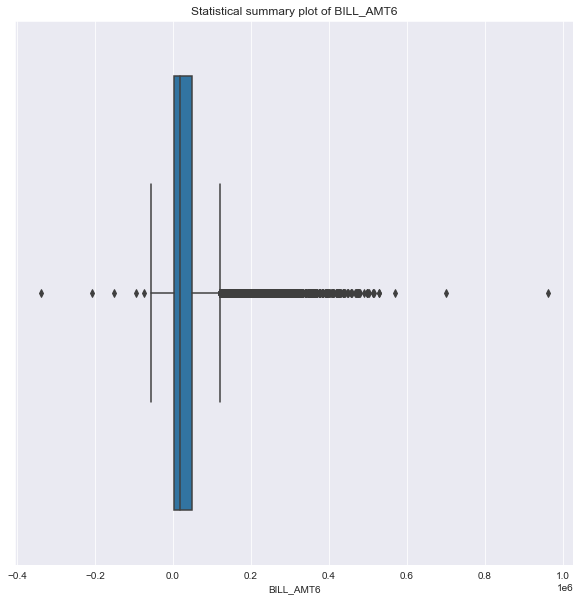

Skewness of BILL_AMT6 is 2.844994744447548.
Kurtosis of BILL_AMT6 is 12.25688040762839.


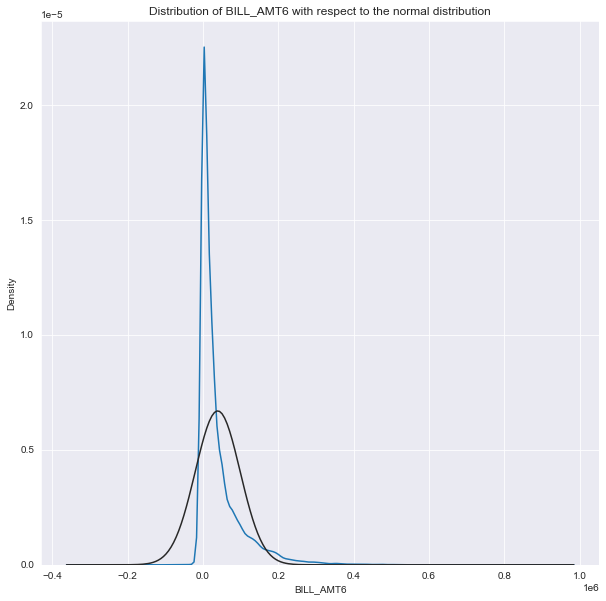



The boxplot and distribution plot of PAY_AMT1 is as shown:


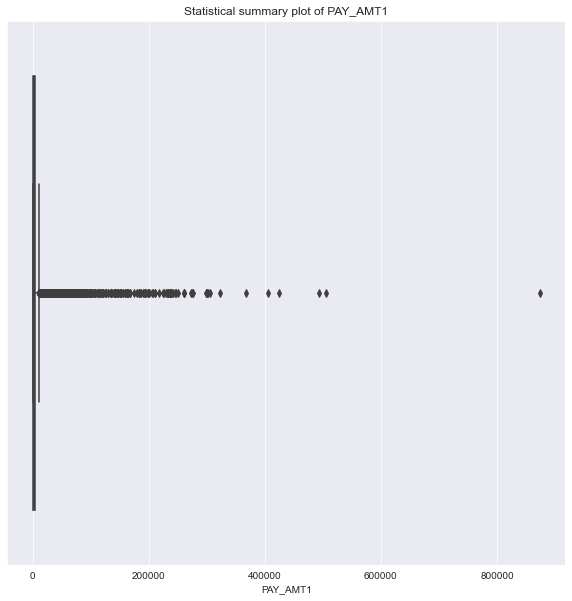

Skewness of PAY_AMT1 is 14.660860590789186.
Kurtosis of PAY_AMT1 is 414.7854430472822.


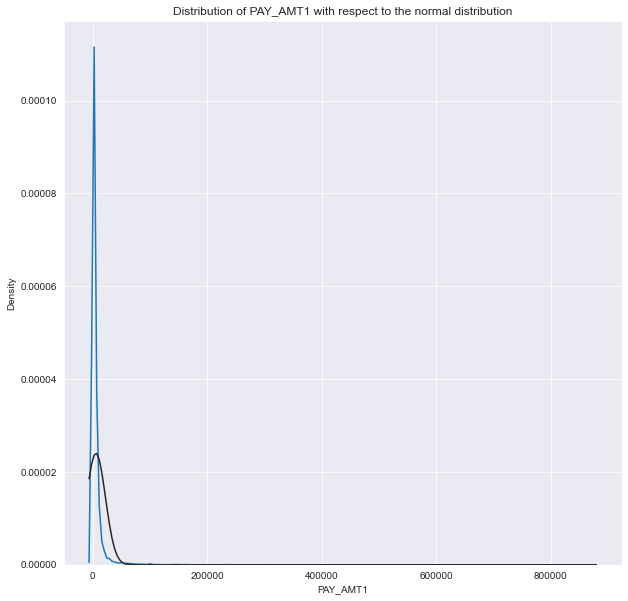



The boxplot and distribution plot of PAY_AMT2 is as shown:


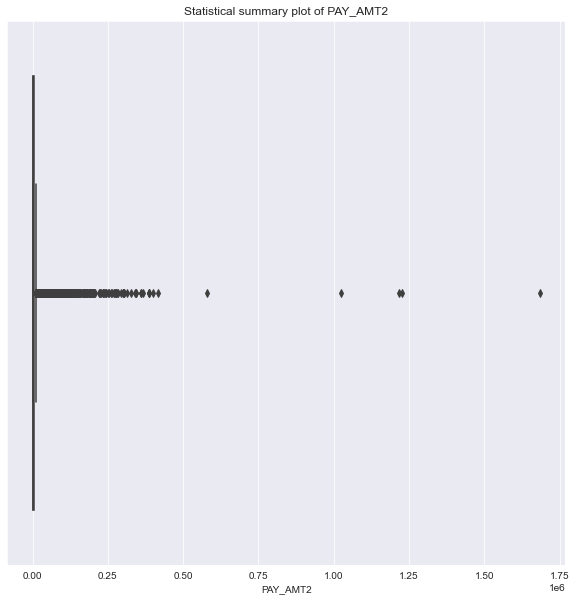

Skewness of PAY_AMT2 is 30.43708919176341.
Kurtosis of PAY_AMT2 is 1639.6506235649251.


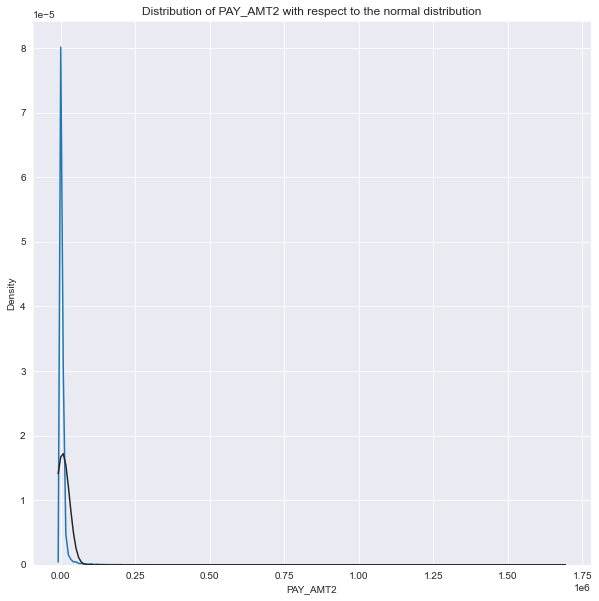



The boxplot and distribution plot of PAY_AMT3 is as shown:


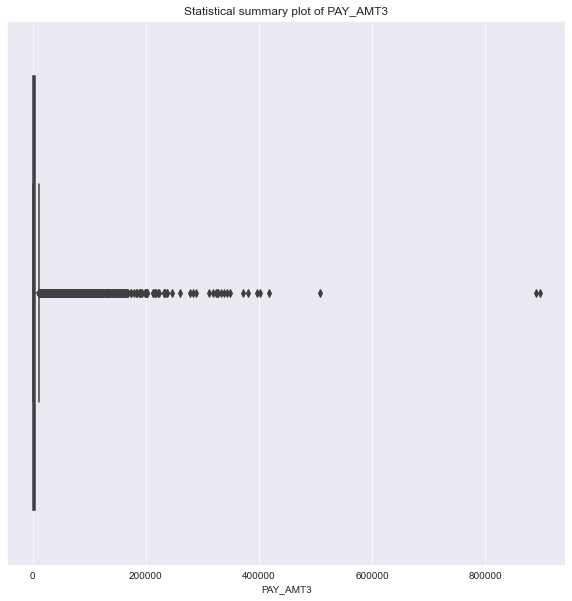

Skewness of PAY_AMT3 is 17.20731517314708.
Kurtosis of PAY_AMT3 is 563.6450149848251.


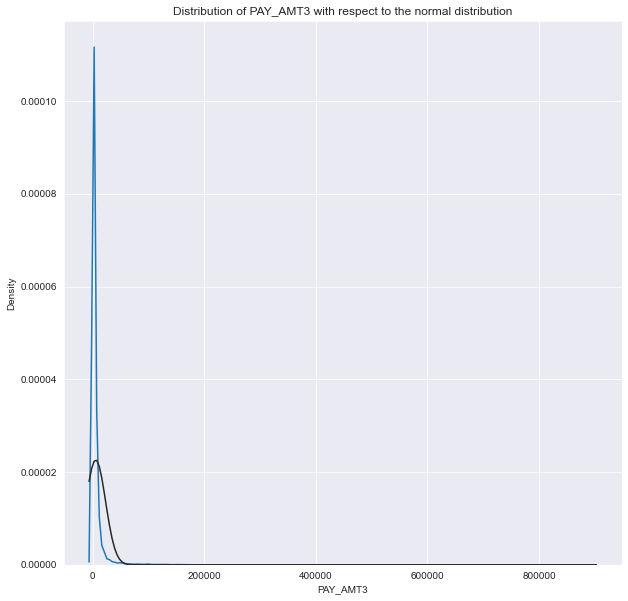



The boxplot and distribution plot of PAY_AMT4 is as shown:


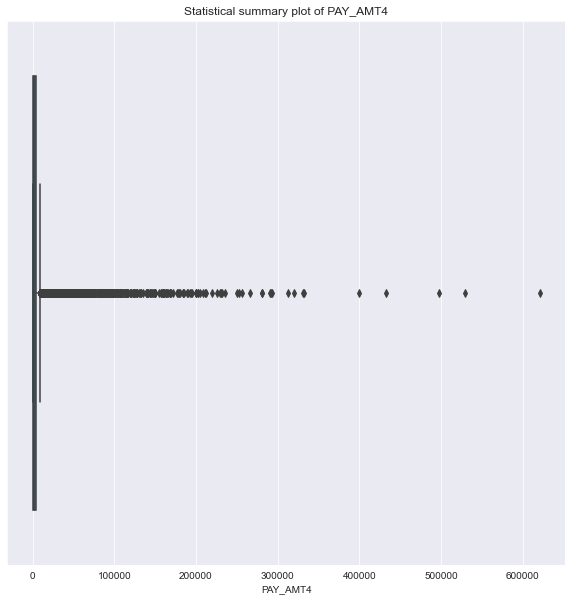

Skewness of PAY_AMT4 is 12.897860804236881.
Kurtosis of PAY_AMT4 is 277.0022663938423.


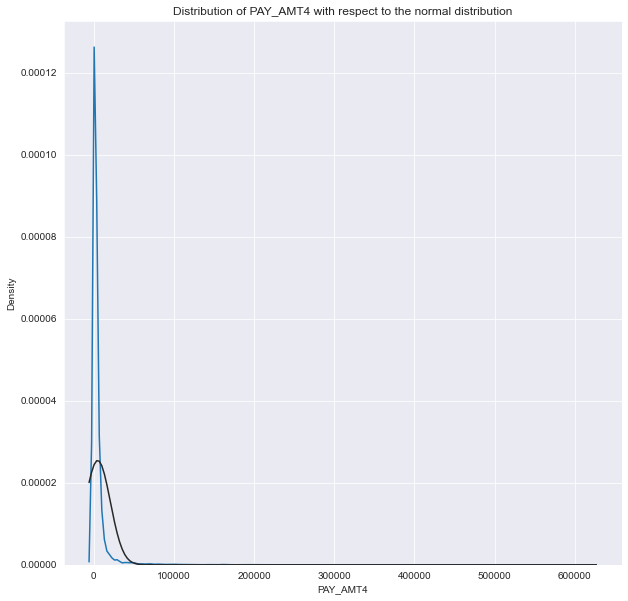



The boxplot and distribution plot of PAY_AMT5 is as shown:


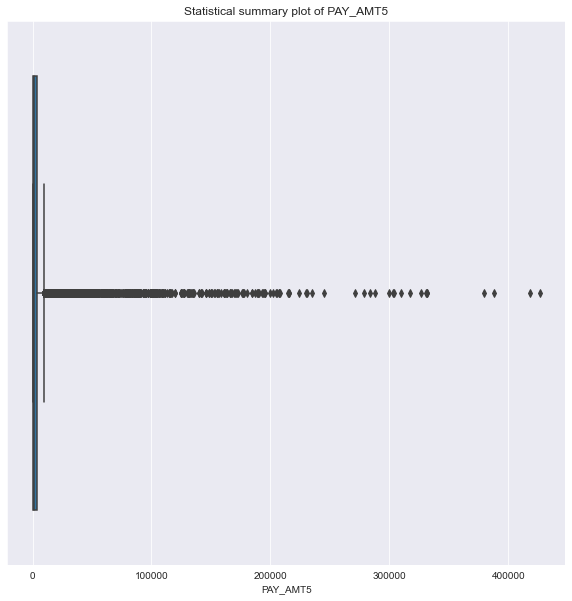

Skewness of PAY_AMT5 is 11.121184995709688.
Kurtosis of PAY_AMT5 is 179.84499640840934.


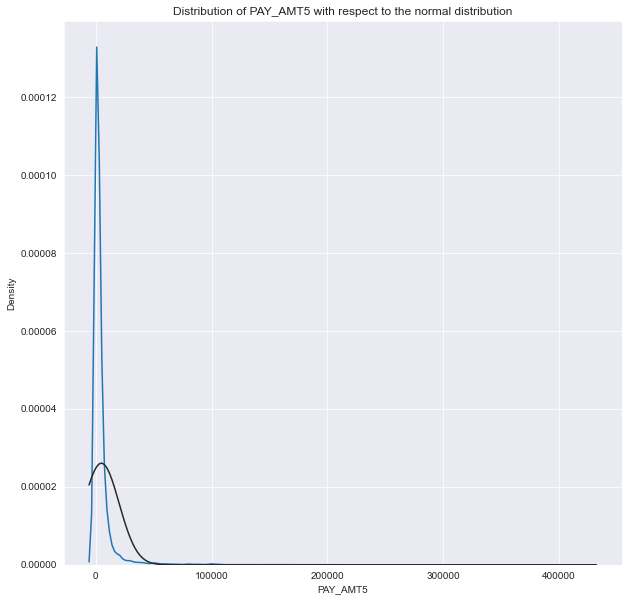



The boxplot and distribution plot of PAY_AMT6 is as shown:


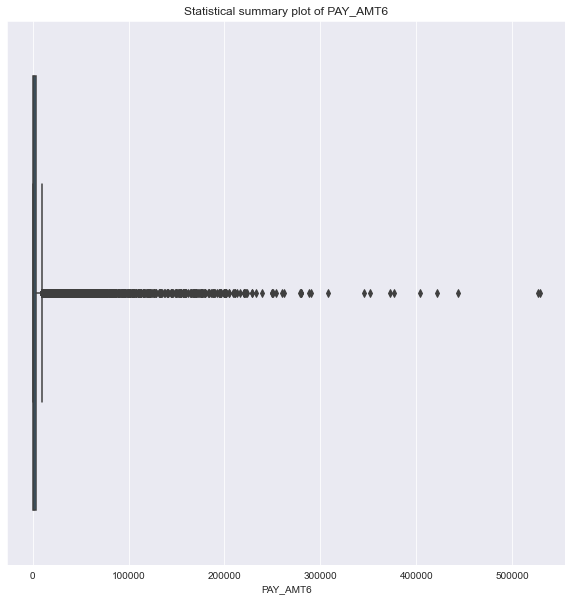

Skewness of PAY_AMT6 is 10.634561587391406.
Kurtosis of PAY_AMT6 is 166.9537279818434.


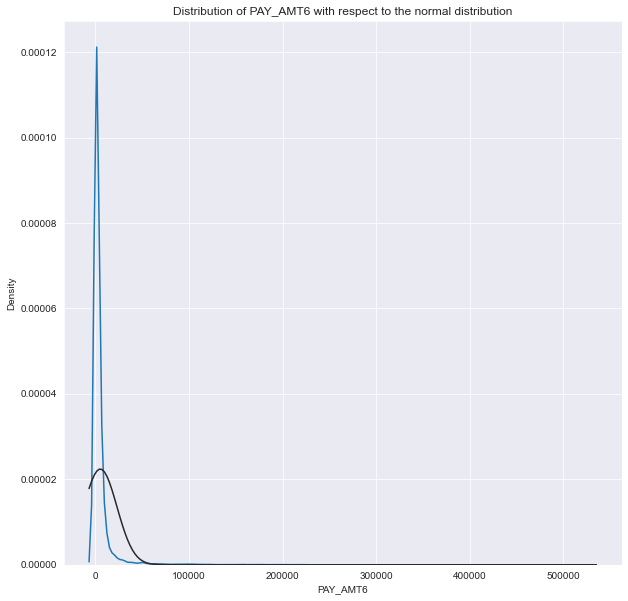

In [13]:
for w in df.dtypes[df.dtypes == 'float64'].index: # Indication of a large number of outliers
    
    print(f'The boxplot and distribution plot of {w} is as shown:')
    sns.boxplot(df[w])
    
    plt.title(f'Statistical summary plot of {w}')
    plt.show()
    
    sns.distplot(df[w], hist = False, fit = norm)
    
    print(f'Skewness of {w} is {skew(df[w])}.')
    print(f'Kurtosis of {w} is {kurtosis(df[w])}.')
    
    plt.title(f'Distribution of {w} with respect to the normal distribution')
    plt.show()
    print('\n')

#### It is clear that all the continuous variables have a high skewness and kurtosis values. 

### Removing the outliers from limit balance, bill amount and pay amount by converting them into nan values. First I will convert the indexs with negative values to NaN values.

In [14]:
for p in df.loc[:,'BILL_AMT1':'BILL_AMT6'].columns:
    df[p][df[p][df[p] < 0].index.tolist()] = np.nan

### Defining function to convert rest of the outliers to NaN values...

In [15]:
def outlier_detection(data_name):  # This function will convert outliers to NaN values
    
    pd.options.mode.chained_assignment = None
    
    for e in data_name.iloc[:,np.where(data_name.dtypes == 'float64')[0].tolist()].columns:
        d = data_name[e].describe()

        IQR = d[-2] - d[-4]

        lower = np.where(data_name[e] < d[-4] - 1.5*IQR)[0]
        upper = np.where(data_name[e] > d[-2] + 1.5*IQR)[0]

        s_l = set(lower)
        s_u = set(upper)

        s = s_l.union(s_u)
        s_arr = np.array([i for i in s])
        
        data_name[e][s_arr] = np.nan
        
    print(f'After converting the outliers to nan values, we see that the overall number of null values in dataset:\n\n{data_name.isnull().sum()}')

In [16]:
outlier_detection(df)

After converting the outliers to nan values, we see that the overall number of null values in dataset:

LIMIT_BAL     167
SEX             0
EDUCATION       0
MARRIAGE        0
AGE             0
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1    2916
BILL_AMT2    2986
BILL_AMT3    3029
BILL_AMT4    3162
BILL_AMT5    3335
BILL_AMT6    3314
PAY_AMT1     2742
PAY_AMT2     2723
PAY_AMT3     2596
PAY_AMT4     2993
PAY_AMT5     2944
PAY_AMT6     2960
default         0
dtype: int64


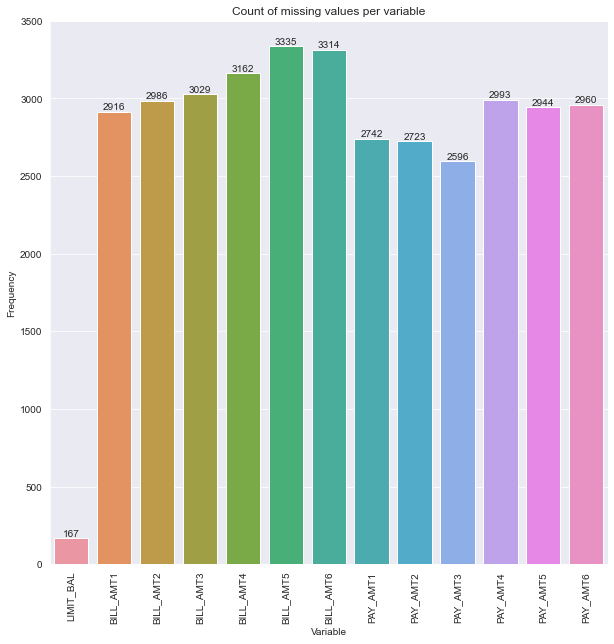

In [17]:
l_c = [t for t in dict(df.isnull().sum()[np.where(df.isnull().sum() > 0)[0]]).values()]
l_n = [u for u in dict(df.isnull().sum()[np.where(df.isnull().sum() > 0)[0]]).keys()]

ax = sns.barplot(x = l_n, y = l_c)

for r in ax.containers:
    ax.bar_label(r)
    
plt.ylabel('Frequency')
plt.xlabel('Variable')
plt.title('Count of missing values per variable')
plt.xticks(rotation = 90)
plt.show()

In [18]:
for i in l_n:
    df[i] = df[i].fillna(df[i].median())
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,2000.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29960,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,2000.0,5003.0,3047.0,5000.0,1000.0,0
29961,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29962,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,1500.0,4200.0,2000.0,3100.0,1
29963,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,2000.0,3409.0,1178.0,1926.0,1187.0,1804.0,1


## Default distribution by variable

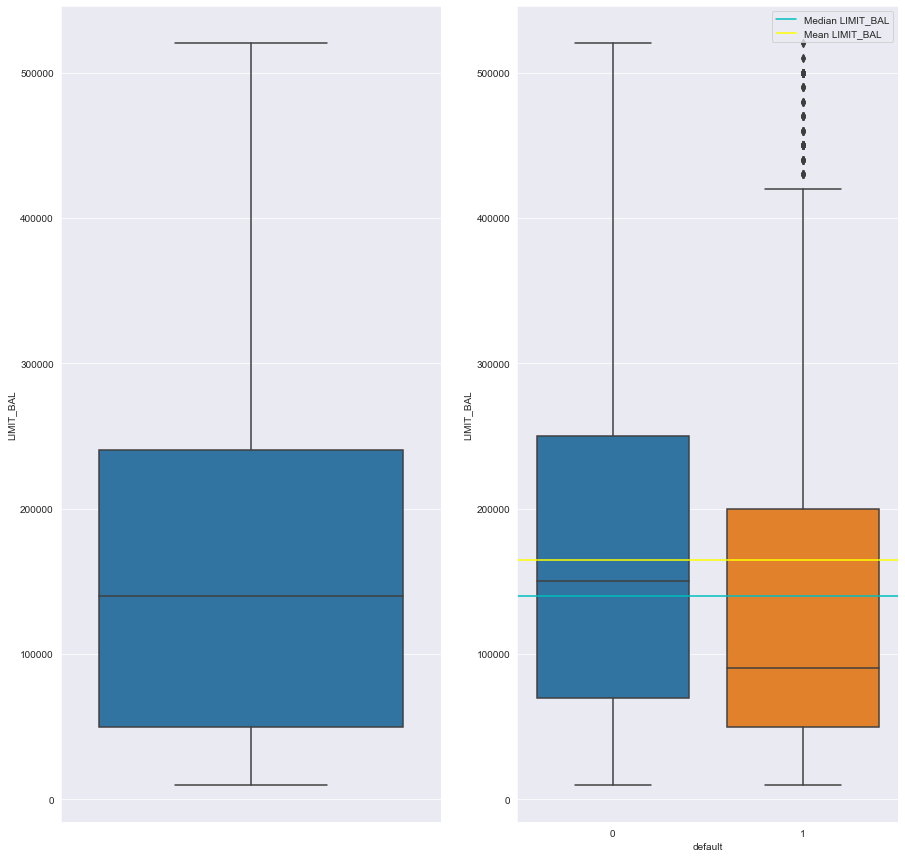

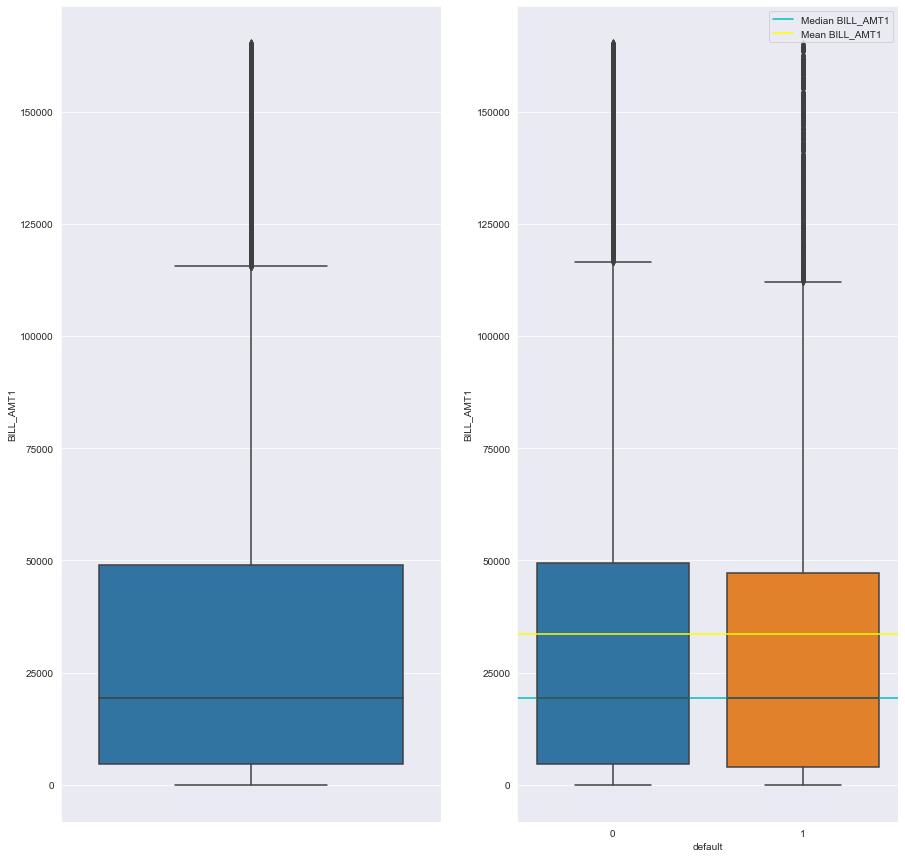

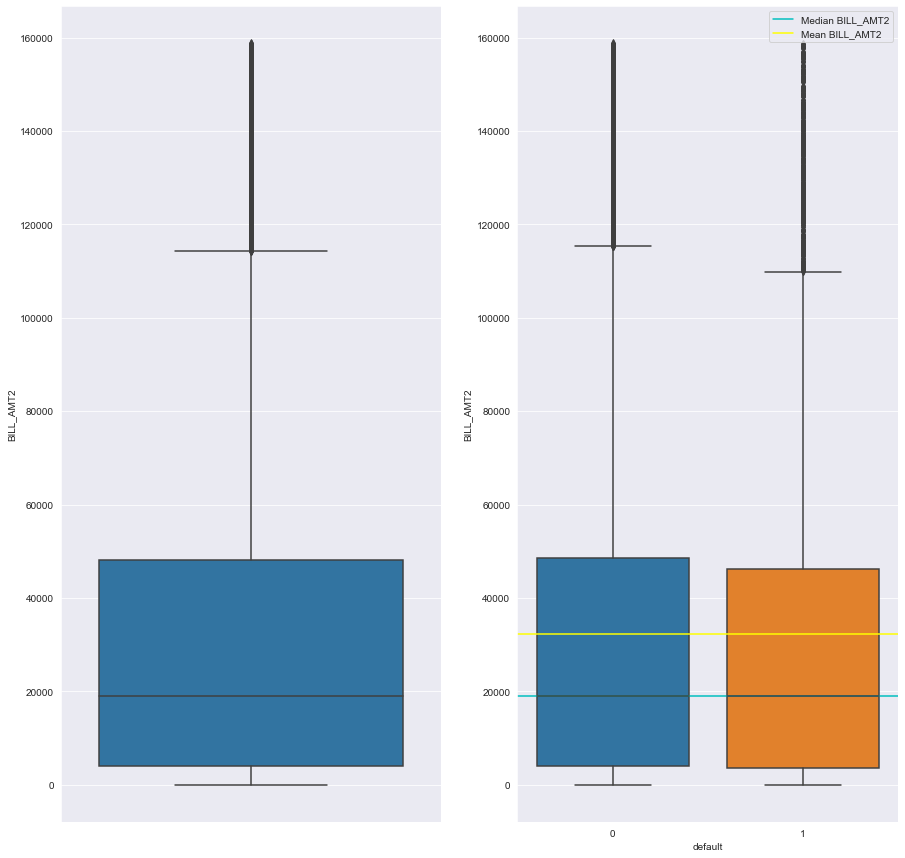

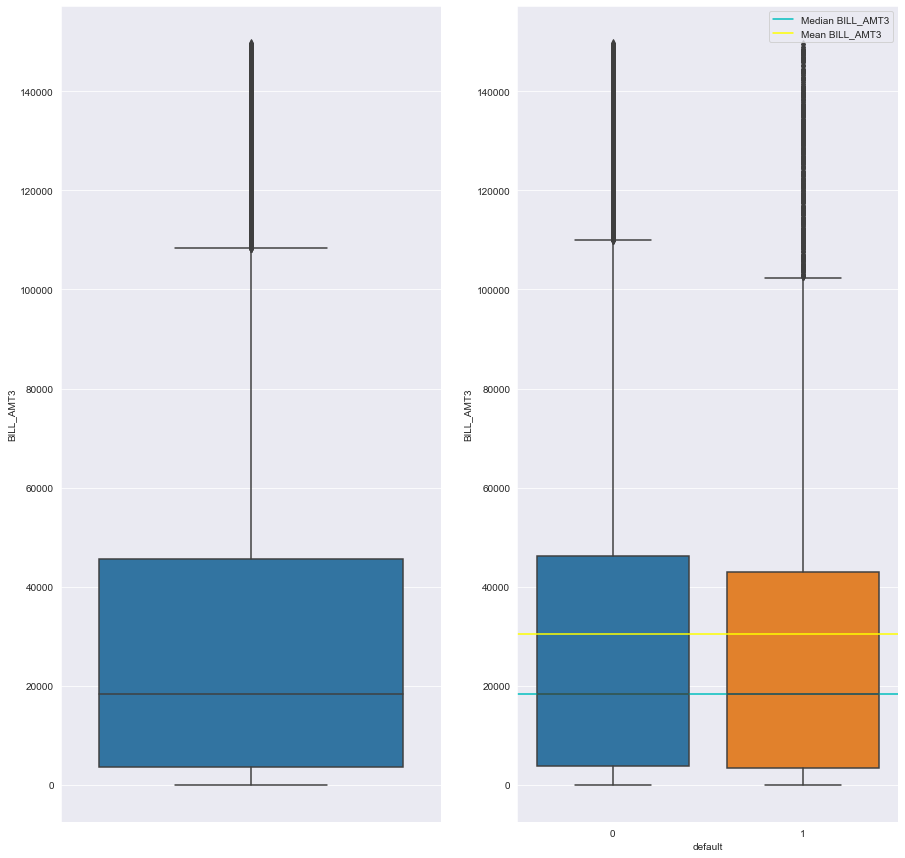

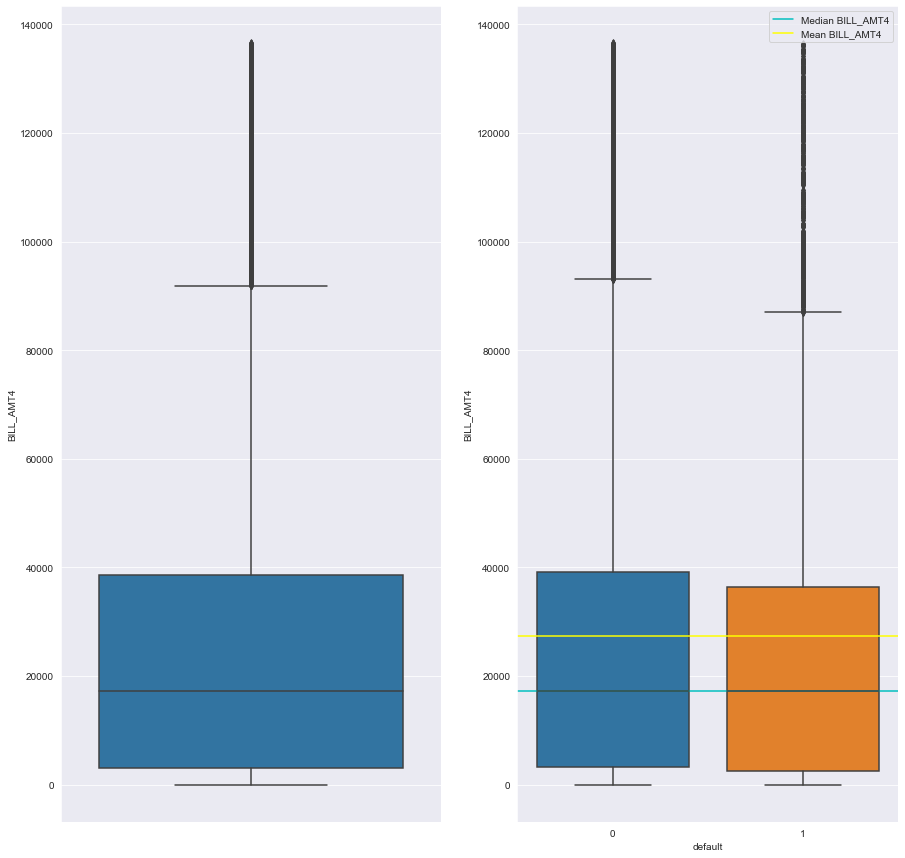

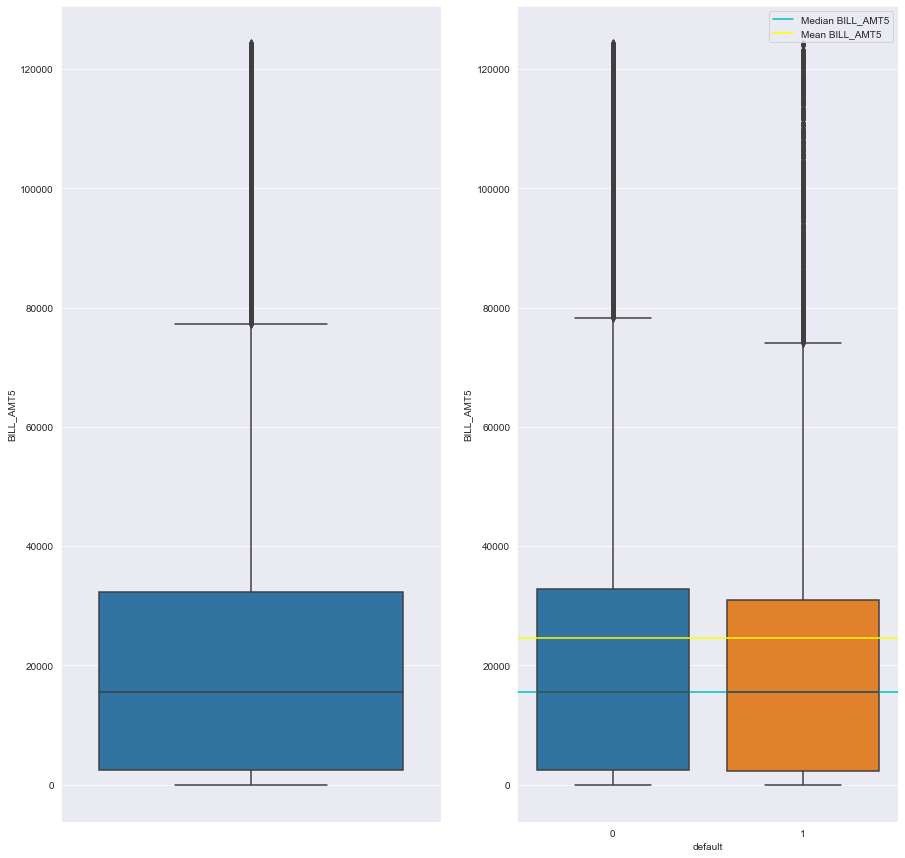

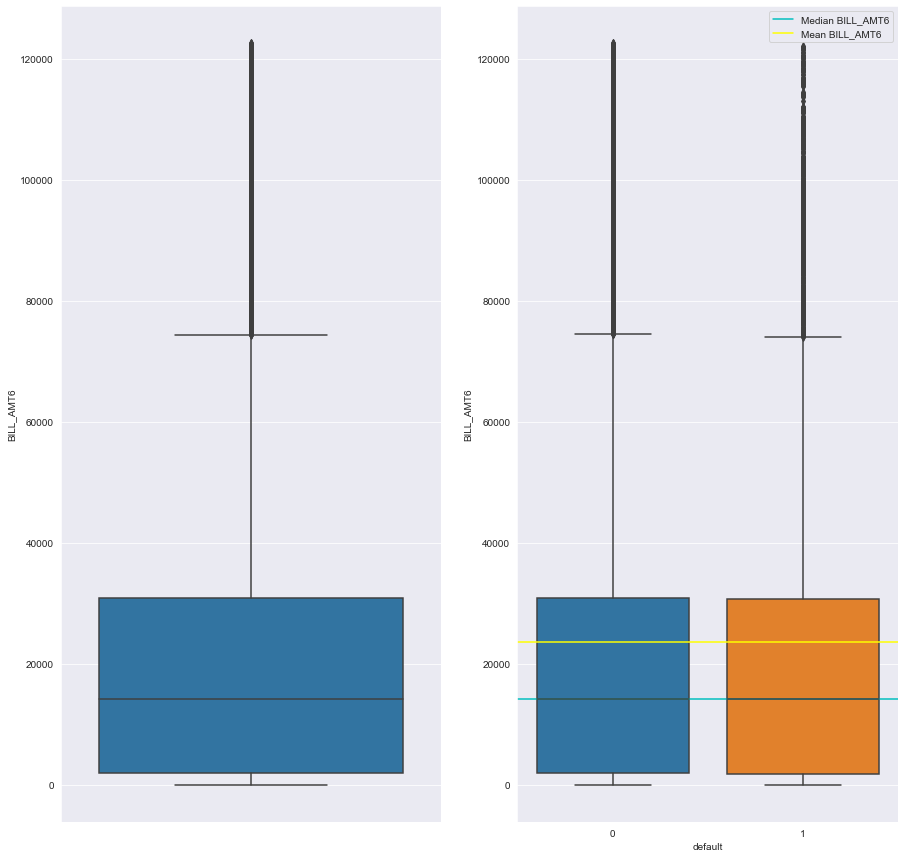

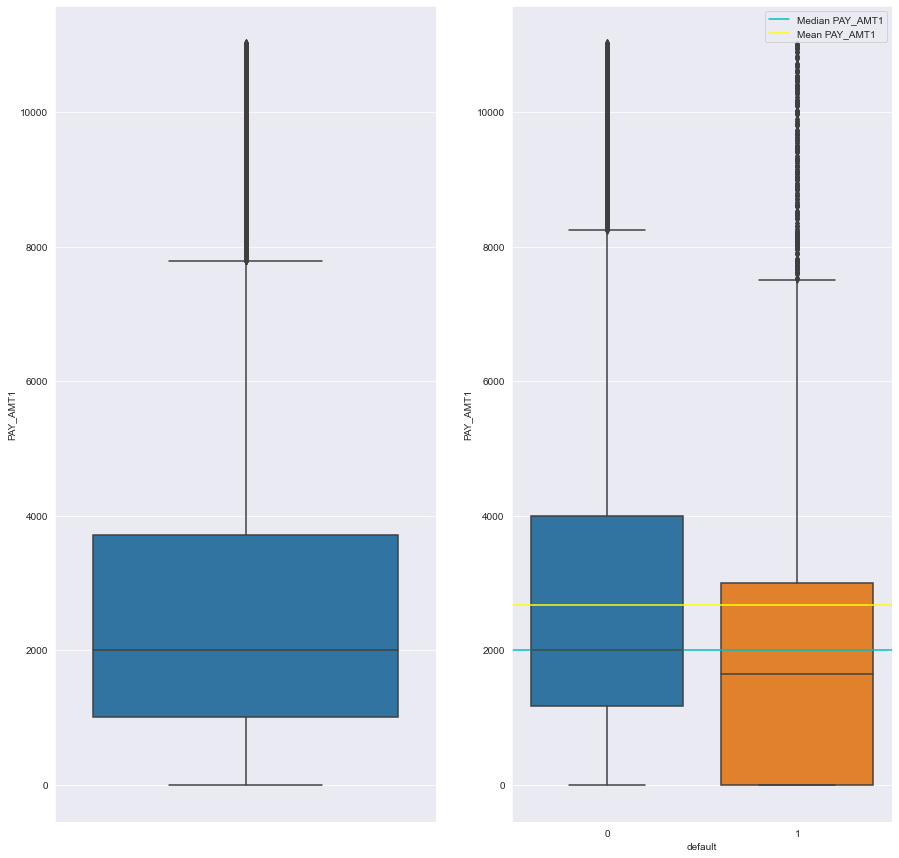

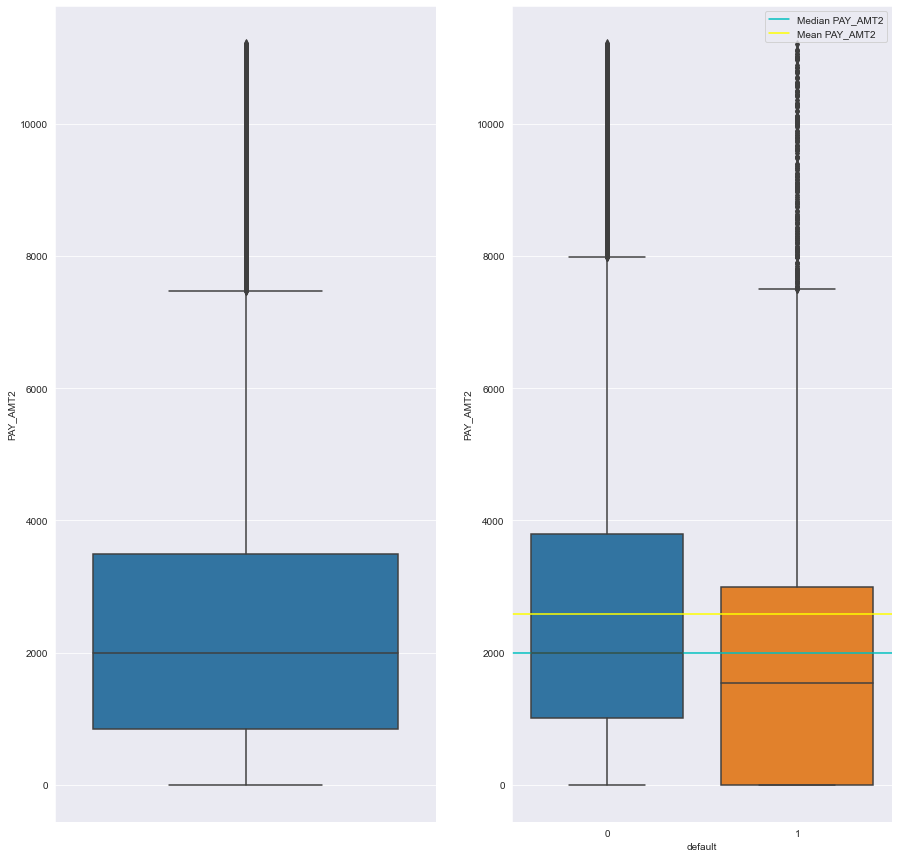

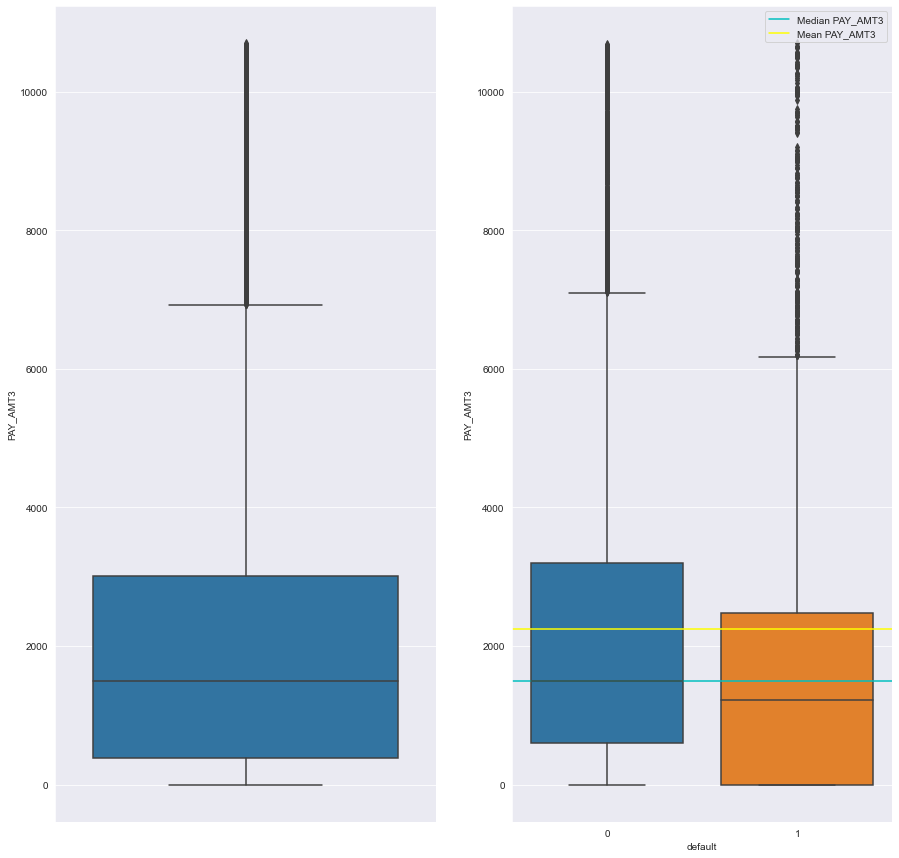

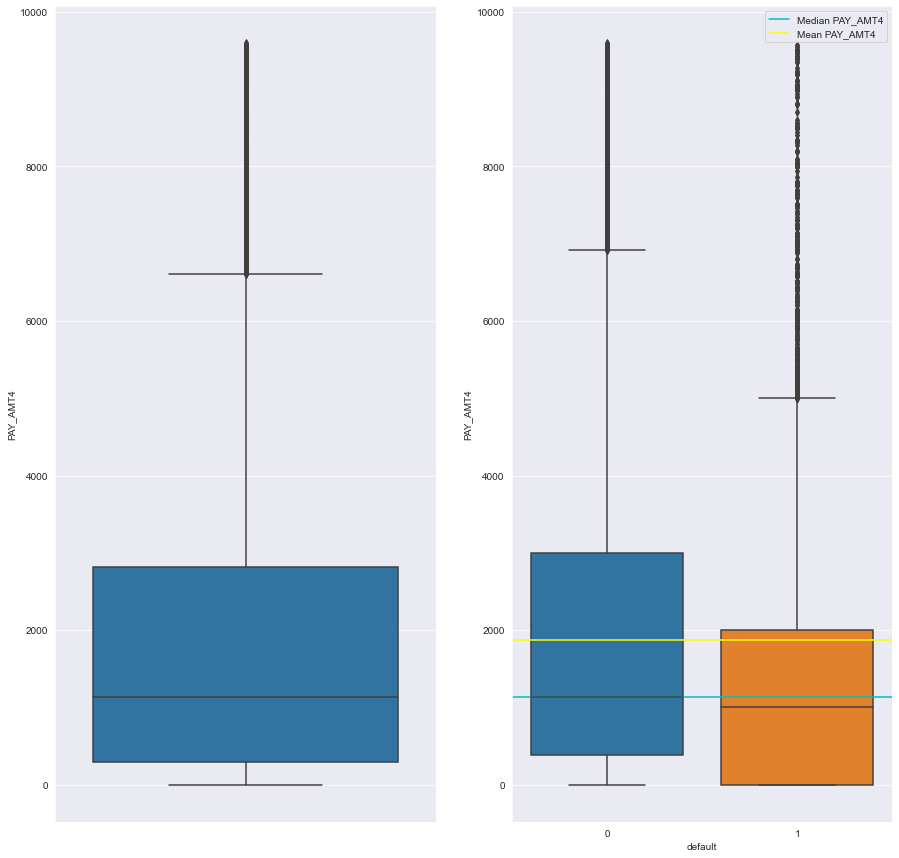

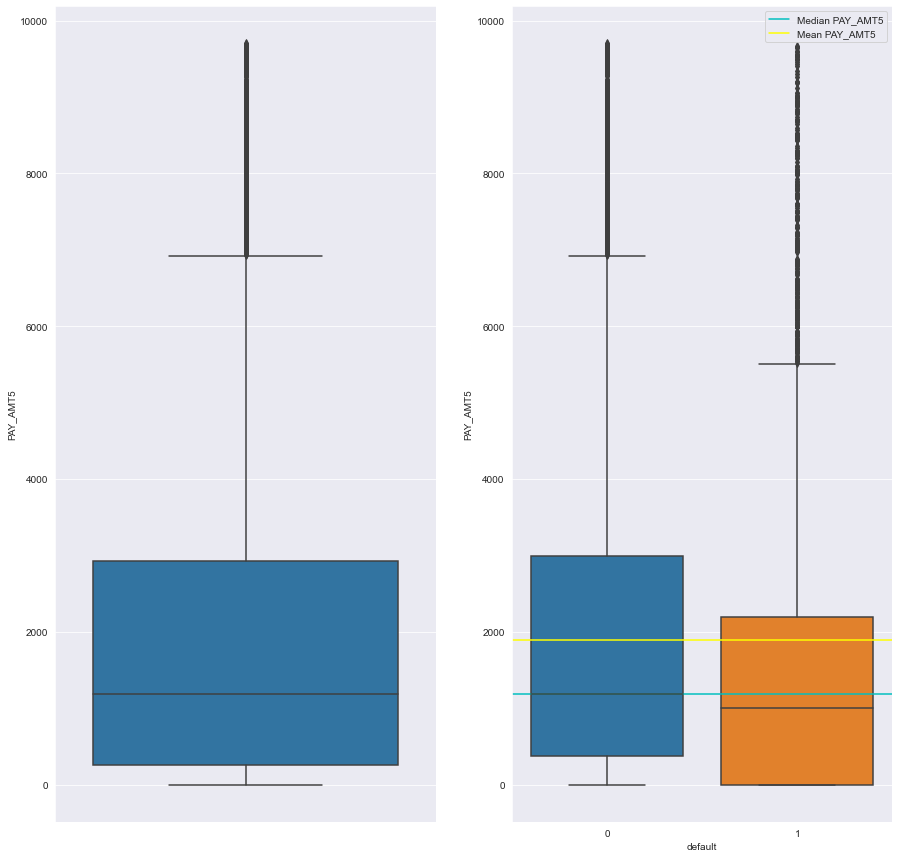

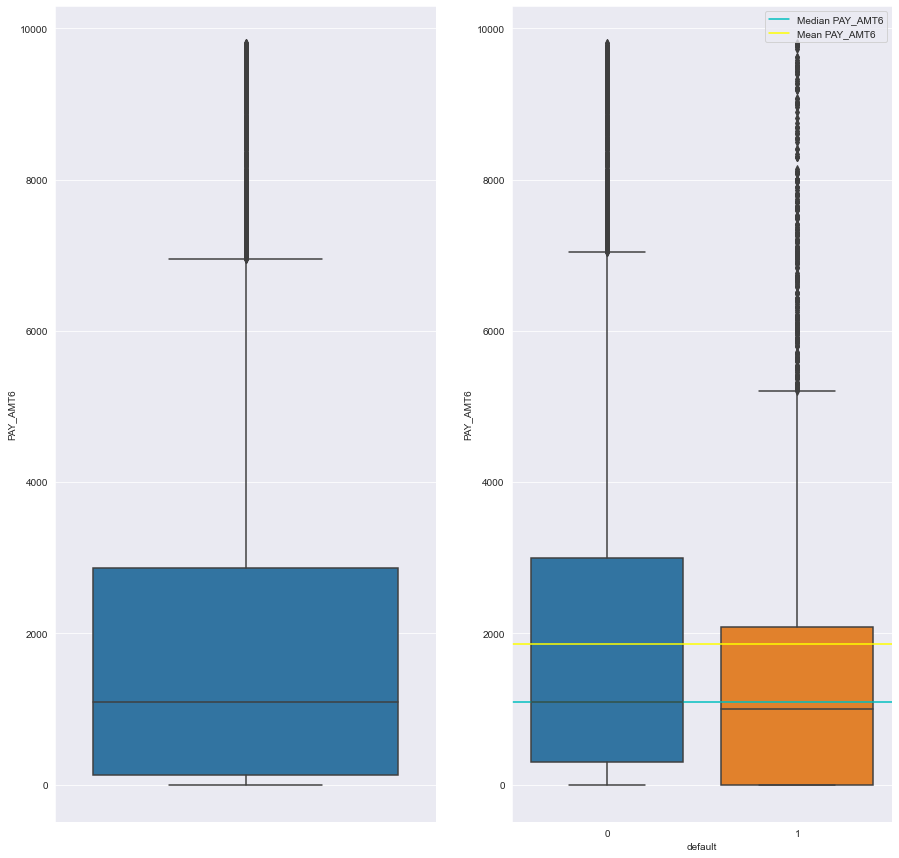

In [19]:
for o in l_n:
    plt.figure(figsize = (15,15))

    plt.subplot(121)
    sns.boxplot(y = df[o])
    
    plt.subplot(122)
    sns.boxplot(x = df['default'], y = df[o])
    plt.axhline(df[o].median(), color = 'c', label = f'Median {o}')
    plt.axhline(df[o].mean(), color = 'yellow', label = f'Mean {o}')
    plt.legend()
    
    plt.show()
    print('\n')

#### Basic inferences can be easily made from above...

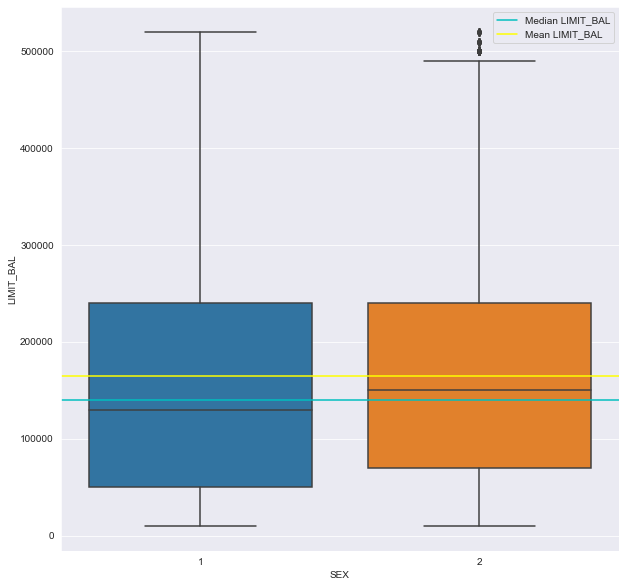

In [20]:
sns.boxplot(x = df['SEX'] , y = df['LIMIT_BAL'])

plt.axhline(df['LIMIT_BAL'].median(), color = 'c', label = 'Median LIMIT_BAL')
plt.axhline(df['LIMIT_BAL'].mean(), color = 'yellow', label = 'Mean LIMIT_BAL')

plt.legend()
plt.show()

## Analysis of discrete variables

Frequency bar plot for SEX: 




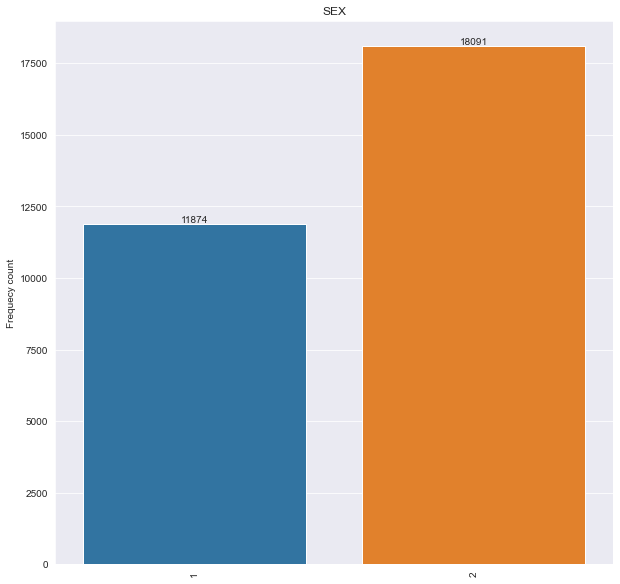

Frequency bar plot for EDUCATION: 




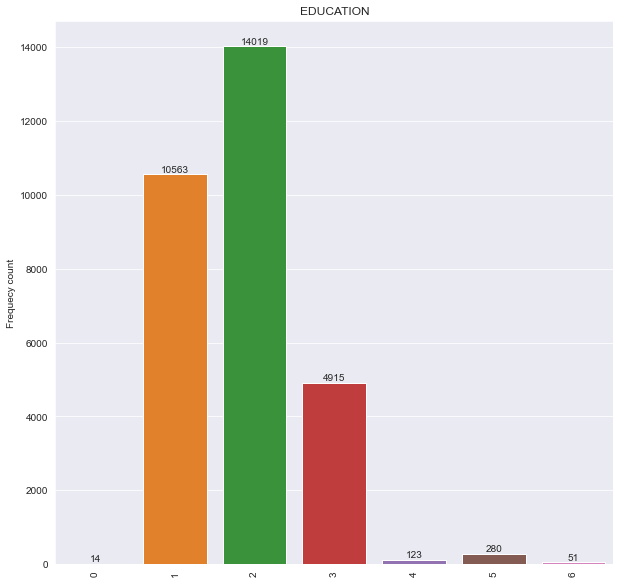

Frequency bar plot for MARRIAGE: 




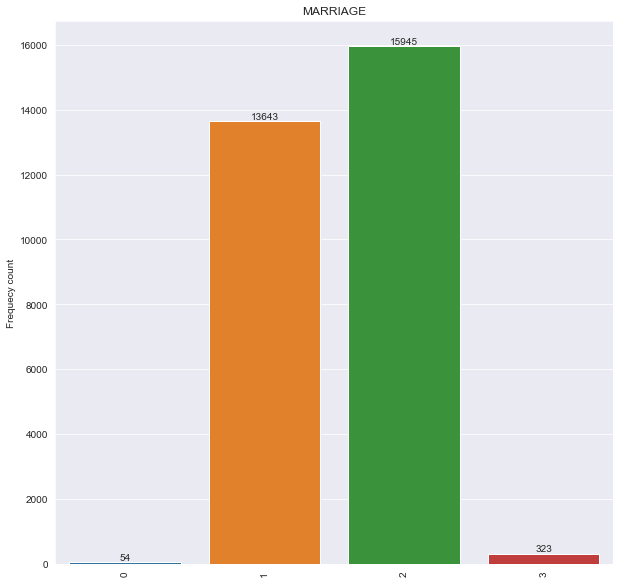

Frequency bar plot for PAY_0: 




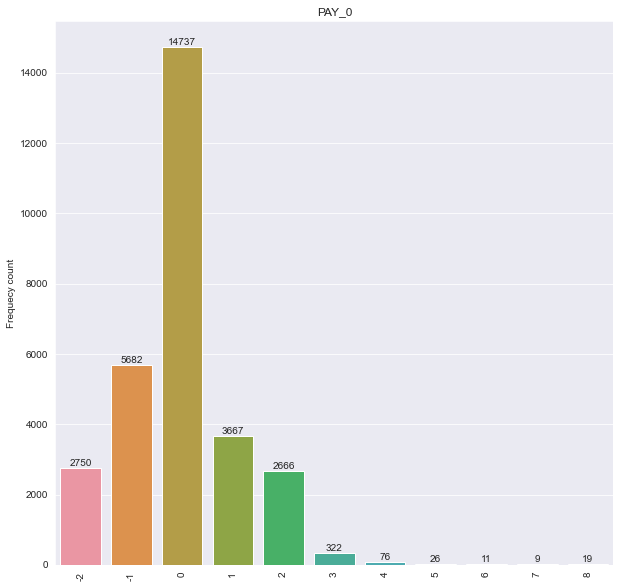

Frequency bar plot for PAY_2: 




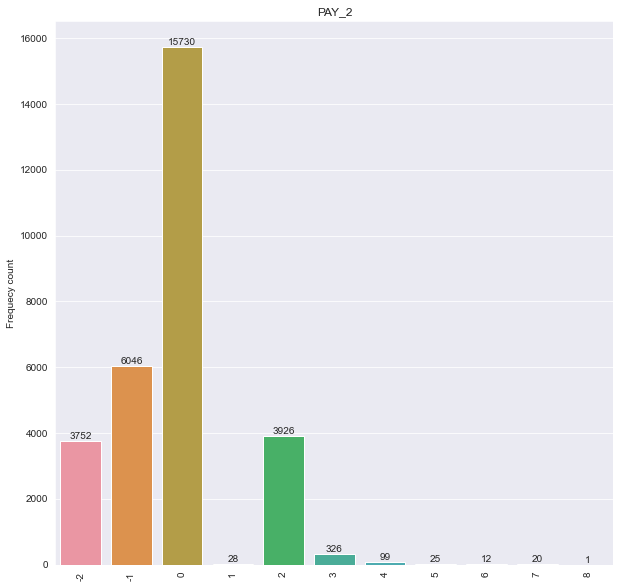

Frequency bar plot for PAY_3: 




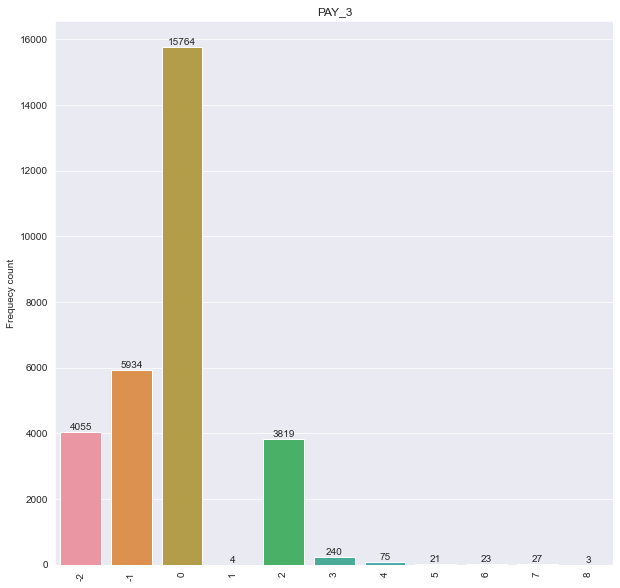

Frequency bar plot for PAY_4: 




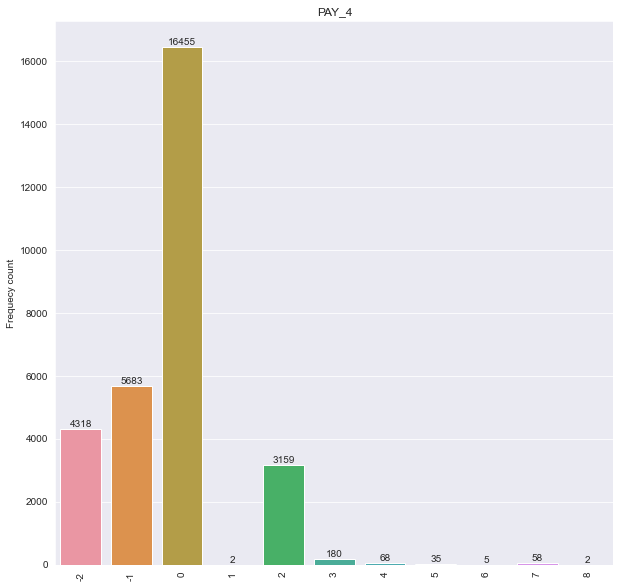

Frequency bar plot for PAY_5: 




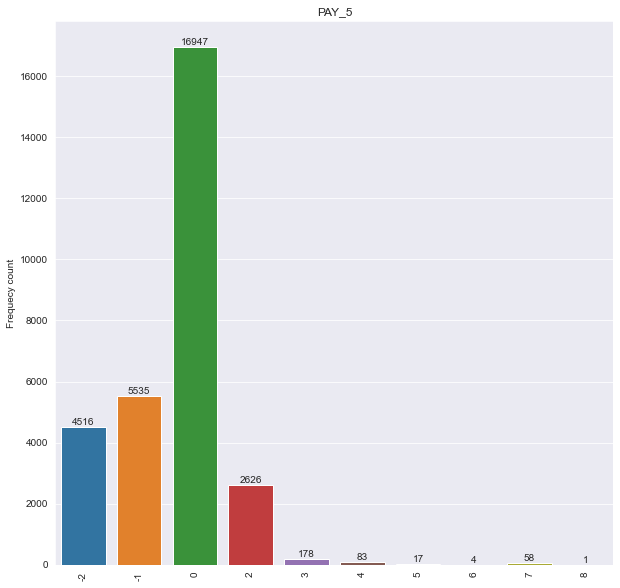

Frequency bar plot for PAY_6: 




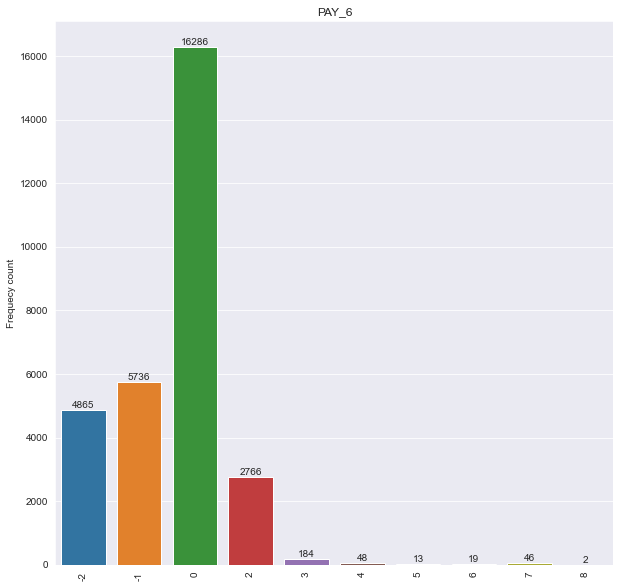

Frequency bar plot for default: 




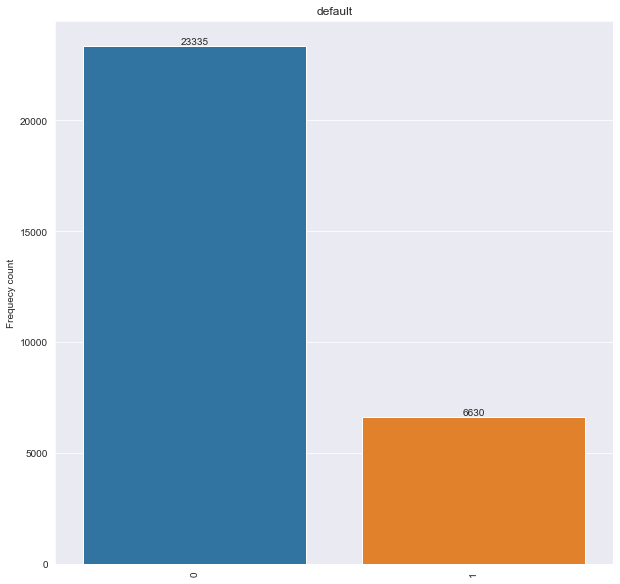

In [21]:
for a in df.iloc[:,np.where(df.dtypes == 'int64')[0].tolist()].drop('AGE',axis = 1).columns:
    
    print(f'Frequency bar plot for {a}: ')
    
    ax = sns.barplot(df[a].value_counts().index.tolist(),df[a].value_counts().values.tolist())
    
    for s in ax.containers:
        ax.bar_label(s)
        
    plt.ylabel('Frequecy count')
    plt.xticks(rotation = 90)
    plt.title(f'{a}')
    print('\n')
    plt.show()

#### For almost all discrete variables, the size distribution is not uniform.

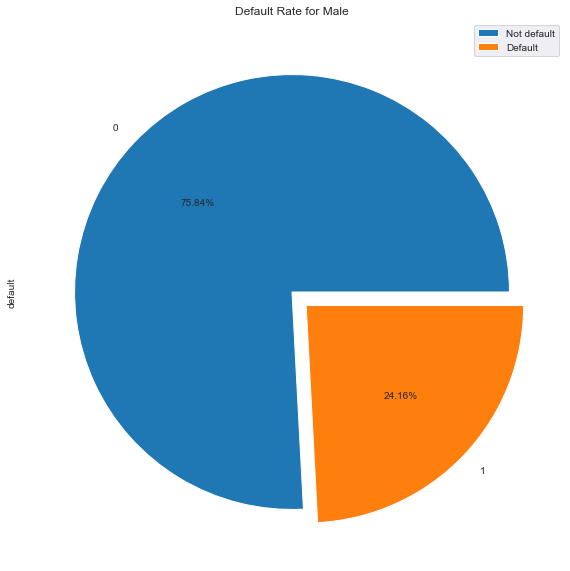

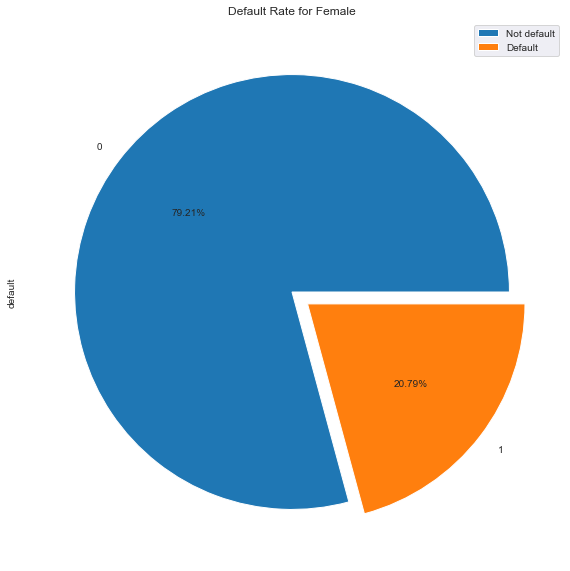

In [22]:
prop_1 = df[df['SEX'] == 1]['default'].value_counts()/sum(df[df['SEX'] == 1]['default'].value_counts())
prop_1.plot(kind = 'pie', autopct = '%.2f%%', explode = [0,0.09])

plt.legend(['Not default','Default'])
plt.title('Default Rate for Male')
plt.show()

prop_2 = df[df['SEX'] == 2]['default'].value_counts()/sum(df[df['SEX'] == 2]['default'].value_counts())
prop_2.plot(kind = 'pie', autopct = '%.2f%%', explode = [0,0.09])

plt.legend(['Not default','Default'])
plt.title('Default Rate for Female')
plt.show()

#### Default rate in males is more compared to females.

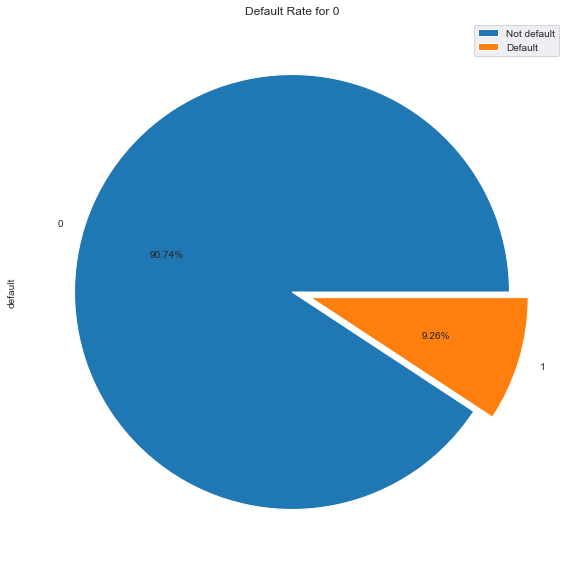

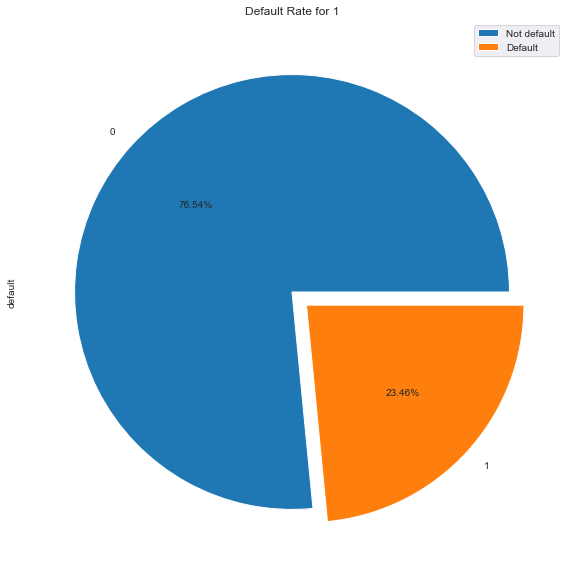

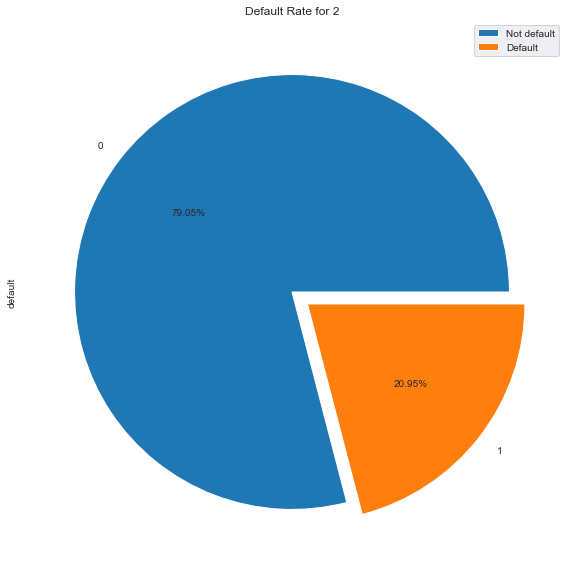

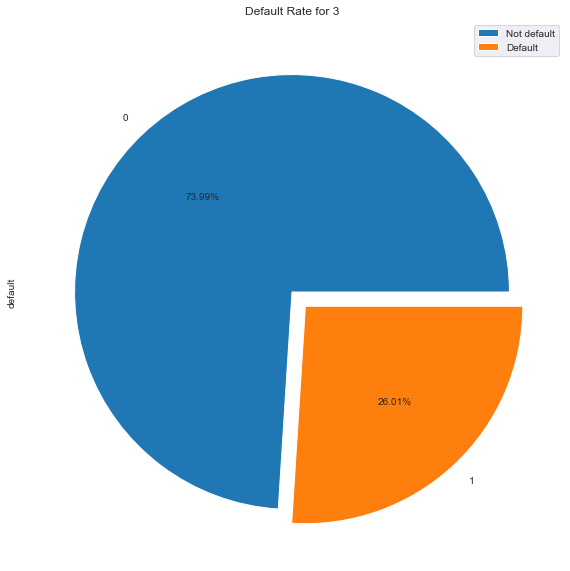

In [23]:
for d in sorted(df['MARRIAGE'].unique()):

    prop = df[df['MARRIAGE'] == d]['default'].value_counts()/sum(df[df['MARRIAGE'] == d]['default'].value_counts())
    prop.plot(kind = 'pie', autopct = '%.2f%%', explode = [0,0.09])
    
    plt.legend(['Not default','Default'])
    plt.title(f'Default Rate for {d}')
    plt.show()

### Age with maximum and minimum default

In [24]:
l_age = []

for g in df['AGE'].value_counts().nlargest(15).index.tolist():
    
    age_value = df[df['AGE'] == g]['default'].value_counts()
    prop = age_value/sum(age_value)
    l_age.append(1-prop[0])
    
max_age = df[df['AGE'] == df['AGE'].value_counts().nlargest(15).index.tolist()[l_age.index(max(l_age))]]['AGE'].unique()[0]
min_age = df[df['AGE'] == df['AGE'].value_counts().nlargest(15).index.tolist()[l_age.index(min(l_age))]]['AGE'].unique()[0]

print(f'Age with maximum default: {max_age}.')
print(f'Age with minimum default: {min_age}.')

Age with maximum default: 24.
Age with minimum default: 33.


## Creating New Columns

In [25]:
df['TOTAL_PAY_AMT'] = df.loc[:,'PAY_AMT1':'PAY_AMT6'].sum(axis = 1)
df['TOTAL_BILL_AMT'] = df.loc[:,'BILL_AMT1':'BILL_AMT6'].sum(axis = 1)
df['PAY_TOTAL'] = df.loc[:,'PAY_0':'PAY_6'].sum(axis = 1)

## Model Building

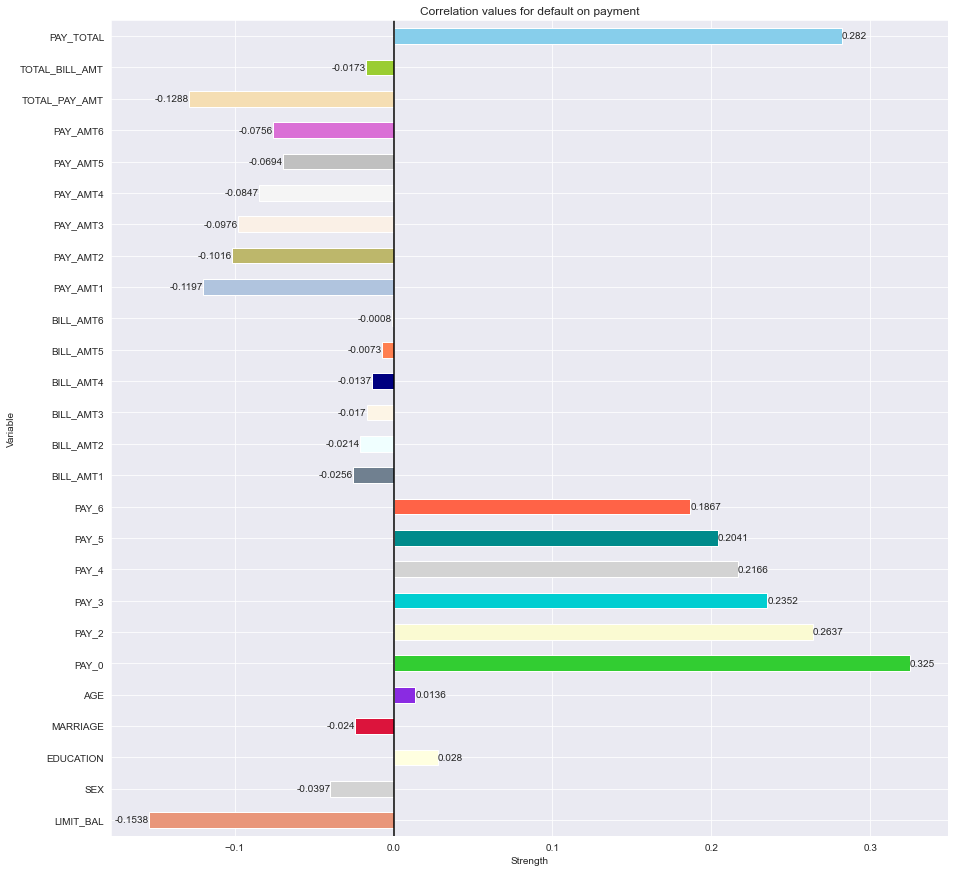

In [26]:
plt.figure(figsize = (15,15))

colors = sample([k for k,v in pltc.cnames.items()], len(df.drop('default',axis=1).columns))

ax = np.round(df.drop('default', axis = 1).corrwith(df['default']), 4).plot(kind = 'barh', color = colors)

for e in ax.containers:
    ax.bar_label(e)
    
plt.axvline(x = 0, color = 'black')
plt.title('Correlation values for default on payment')
plt.xlabel('Strength')
plt.ylabel('Variable')
plt.show()

In [27]:
x = df.drop('default',axis = 1)
y = df.loc[:,['default']]

resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x, y = resample.fit_resample(x, y)

x = pd.DataFrame(x, columns = x.columns)

In [28]:
model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()

model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()

model_bnb = BernoulliNB()
model_gbr = GradientBoostingClassifier()

model_xgb = xgboost.XGBClassifier(eval_metric = 'error')
model_xgbrf = xgboost.XGBRFClassifier(eval_metric = 'error')

model_abr = AdaBoostClassifier()
model_etr = ExtraTreesClassifier()

model_hgr = HistGradientBoostingClassifier()
model_lgb = lgbm.LGBMClassifier()

In [29]:
l_model = [model_lr, model_knn, model_dt, model_rf, model_bnb, model_gbr,model_xgbrf,
           model_xgb, model_abr, model_etr, model_hgr, model_lgb]

### Using Cross Validation

In [30]:
l_acc = []
l_err = []
l_std = []
l_cv = []
l_exe_time = []



for j in l_model:
    start_time = time.time()
    
    l_acc.append(cross_val_score(j, x,y).mean())
    l_err.append(1-cross_val_score(j, x,y).mean())
    l_std.append(cross_val_score(j, x,y).std())
    l_cv.append(cross_val_score(j, x,y).std()/cross_val_score(j, x,y).mean())
    
    l_exe_time.append(time.time() - start_time)

df_i = pd.DataFrame(data=[l_acc, l_err, l_std, l_cv]).T

df_i.columns = ['Accuracy','Error','Std_Deviation','COV']
df_i.index = ['LogisticRegression()','KNeighborsClassifier()','DecisionTreeClassifier()',
              'RandomForestClassifier()','BernoulliNB()','GradientBoostingClassifier()','XGBRFClassifier()',
              'XGBClassifier()','AdaBoostClassifier()','ExtraTreesClassifier()',
              'HistGradientBoostingClassifier()','LGBMClassifier()']

df_acc = df_i
df_acc

,Accuracy,Error,Std_Deviation,COV
LogisticRegression(),0.546844,0.453156,0.005880,0.010753
KNeighborsClassifier(),0.751876,0.248124,0.015318,0.020373
DecisionTreeClassifier(),0.753095,0.247340,0.060601,0.080488
RandomForestClassifier(),0.837543,0.161783,0.075453,0.088761
BernoulliNB(),0.688257,0.311743,0.006904,0.010031
GradientBoostingClassifier(),0.778469,0.221488,0.068981,0.088609
XGBRFClassifier(),0.759726,0.240274,0.046290,0.060930
XGBClassifier(),0.816106,0.183894,0.101290,0.124113
AdaBoostClassifier(),0.760118,0.239882,0.065900,0.086697
ExtraTreesClassifier(),0.847001,0.153521,0.070306,0.078998


#### Therefore, in terms of cross validation accuracy and COV, the best model is ExtraTreesClassifier( ) with a value of 0.84 and 0.078 respectively. It is followed by RandomForestClassifier. Worst performing model here is LogisticRegression( ). 

### Using Matthews Correlation Coefficient (MCC)

In [31]:
l_mcc = []

for b in l_model:
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42)
    b.fit(x_train, y_train)
    y_predict = b.predict(x_test)

    l_mcc.append(matthews_corrcoef(y_test, y_predict))
    
df_in = pd.DataFrame(data=[l_acc, l_err, l_mcc]).T
df_in.columns = ['Accuracy','Error','MCC']
df_in.index = df_i.index

df_acc_mcc = df_in
df_acc_mcc

,Accuracy,Error,MCC
LogisticRegression(),0.546844,0.453156,0.121893
KNeighborsClassifier(),0.751876,0.248124,0.495108
DecisionTreeClassifier(),0.753095,0.247340,0.510530
RandomForestClassifier(),0.837543,0.161783,0.689524
BernoulliNB(),0.688257,0.311743,0.396544
GradientBoostingClassifier(),0.778469,0.221488,0.579476
XGBRFClassifier(),0.759726,0.240274,0.541561
XGBClassifier(),0.816106,0.183894,0.667370
AdaBoostClassifier(),0.760118,0.239882,0.547337
ExtraTreesClassifier(),0.847001,0.153521,0.706576


#### Therefore, in terms of MCC, the best model will be ExtraTreesClassifier( ). MCC is high only if the classifier is doing well on both the negative and the positive classes. It is closely followed by RandomForestClassifier. The worst performing model here is LogisticRegression( ). Also, with the exception of Logistic Regression, almost all the other algorithms have more or less the same amount of error rate.... 

### Using Cohen Kappa Score (CKS)

In [32]:
l_cks = []

for n in l_model:
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42)
    n.fit(x_train, y_train)
    y_predict = n.predict(x_test)

    l_cks.append(cohen_kappa_score(y_test, y_predict))
    
df_in_bt = pd.DataFrame(data=[l_acc, l_err, l_cks]).T
df_in_bt.columns = ['Accuracy','Error','CKS']
df_in_bt.index = df_in.index

df_acc_cks = df_in_bt
df_acc_cks

,Accuracy,Error,CKS
LogisticRegression(),0.546844,0.453156,0.106596
KNeighborsClassifier(),0.751876,0.248124,0.481359
DecisionTreeClassifier(),0.753095,0.247340,0.516929
RandomForestClassifier(),0.837543,0.161783,0.678838
BernoulliNB(),0.688257,0.311743,0.378426
GradientBoostingClassifier(),0.778469,0.221488,0.578415
XGBRFClassifier(),0.759726,0.240274,0.539700
XGBClassifier(),0.816106,0.183894,0.666034
AdaBoostClassifier(),0.760118,0.239882,0.546836
ExtraTreesClassifier(),0.847001,0.153521,0.699865


#### CKS mimics the same effect that MCC does for the average validation accuracy of the model. A  high CKS value is only obtained if the classifier is performing well for TN, TP, FN & FP for all the classes involved. Again, the results obtained here are the same as before.

### Using AUC Score

In [33]:
l_auc = []

for m in l_model:
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42)
    m.fit(x_train, y_train)

    l_auc.append(roc_auc_score(y_test, m.predict(x_test)))
    
df_in_bt_f = pd.DataFrame(data=[l_acc, l_err, l_auc]).T
df_in_bt_f.columns = ['Accuracy','Error','AUC']
df_in_bt_f.index = df_in_bt.index

df_acc_auc = df_in_bt_f
df_acc_auc

,Accuracy,Error,AUC
LogisticRegression(),0.546844,0.453156,0.554280
KNeighborsClassifier(),0.751876,0.248124,0.738597
DecisionTreeClassifier(),0.753095,0.247340,0.755121
RandomForestClassifier(),0.837543,0.161783,0.844944
BernoulliNB(),0.688257,0.311743,0.691346
GradientBoostingClassifier(),0.778469,0.221488,0.789862
XGBRFClassifier(),0.759726,0.240274,0.770687
XGBClassifier(),0.816106,0.183894,0.833805
AdaBoostClassifier(),0.760118,0.239882,0.773855
ExtraTreesClassifier(),0.847001,0.153521,0.849219


#### A  high AUC score implies a high degree of accuracy of the classification done by the classifier. As expected, the results obtained here are again same as before.

### Model providing best results for all 4 metrics

In [34]:
df_acc_auc[df_acc_auc['AUC'] == max(df_acc_auc['AUC'])].index[0] # Best AUC Score

'ExtraTreesClassifier()'

In [35]:
df_acc[df_acc['Accuracy'] == max(df_acc['Accuracy'])].index[0] # Best Avg Validation Accuracy

'ExtraTreesClassifier()'

In [36]:
df_acc_mcc[df_acc_mcc['MCC'] == max(df_acc_mcc['MCC'])].index[0] # Best MCC Value

'ExtraTreesClassifier()'

In [37]:
df_acc_cks[df_acc_cks['CKS'] == max(df_acc_cks['CKS'])].index[0] # Best CKS Value

'ExtraTreesClassifier()'

## Results

In [38]:
l_test_acc = []
l_train_acc = []
l_tt_diff = []


for mq in l_model:
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42, stratify = y)
    mq.fit(x_train, y_train)
    y_predict = mq.predict(x_test)

    l_train_acc.append(mq.score(x_train,y_train))
    l_test_acc.append(accuracy_score(y_test, y_predict))
    l_tt_diff.append(abs(accuracy_score(y_test, y_predict) - mq.score(x_train,y_train)))

df_test_op_in = pd.DataFrame(data=[l_train_acc, l_test_acc, l_tt_diff]).T
df_test_op_in.columns = ['Train_Acc','Test_Acc','Difference']
df_test_op_in.index = df_in_bt_f.index

df_test_op = df_test_op_in
df_test_op

,Train_Acc,Test_Acc,Difference
LogisticRegression(),0.550386,0.547613,0.002773
KNeighborsClassifier(),0.829101,0.744500,0.084601
DecisionTreeClassifier(),0.999188,0.758936,0.240253
RandomForestClassifier(),0.999188,0.843552,0.155637
BernoulliNB(),0.692091,0.686755,0.005336
GradientBoostingClassifier(),0.796370,0.793808,0.002562
XGBRFClassifier(),0.775613,0.769632,0.005981
XGBClassifier(),0.910854,0.835986,0.074868
AdaBoostClassifier(),0.769293,0.770241,0.000948
ExtraTreesClassifier(),0.999188,0.851031,0.148158


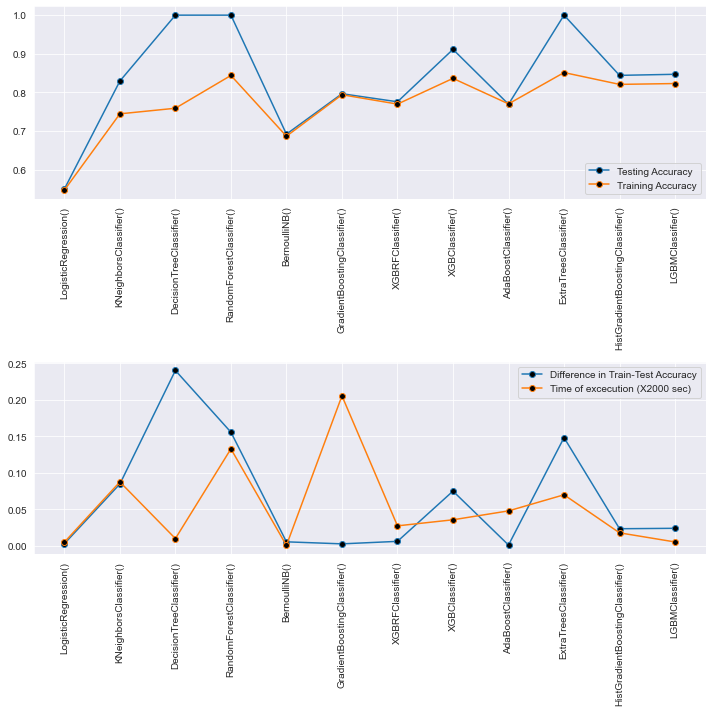

In [39]:
plt.subplot(211)
plt.plot(df_i.index, df_test_op['Train_Acc'], marker = 'o', markerfacecolor = 'k', label = 'Testing Accuracy')
plt.plot(df_i.index, df_test_op['Test_Acc'],marker = 'o', markerfacecolor = 'k' , label = 'Training Accuracy')
plt.xticks(rotation = 90)
plt.legend()

plt.subplot(212)
plt.plot(df_i.index, df_test_op['Difference'],marker = 'o', markerfacecolor = 'k',
         label = 'Difference in Train-Test Accuracy')
plt.plot(df_i.index, [qw/2000 for qw in l_exe_time], marker = 'o', markerfacecolor = 'k',
         label = 'Time of excecution (X2000 sec)')
plt.xticks(rotation = 90)
plt.legend()

plt.tight_layout()
plt.show()

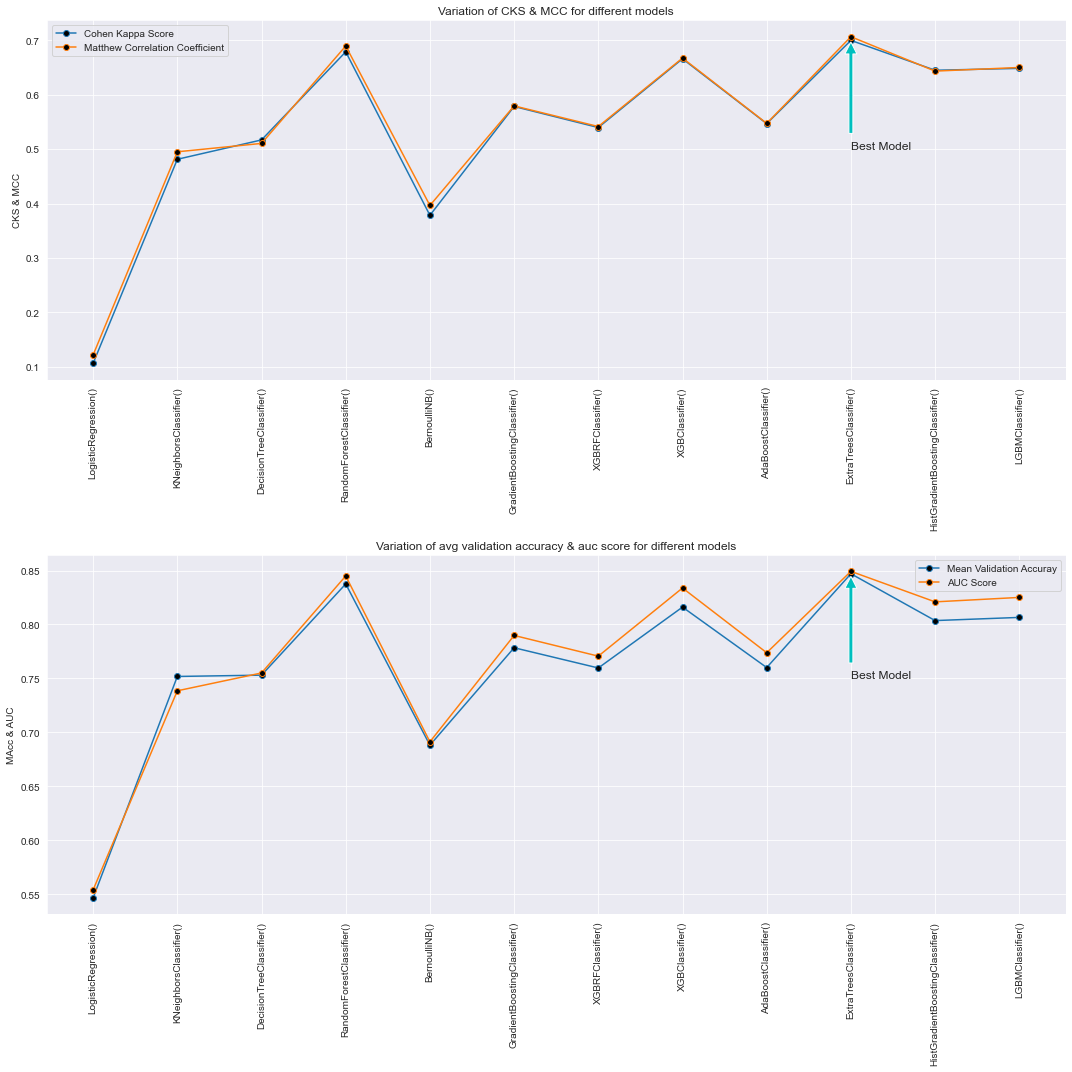

In [40]:
plt.figure(figsize = (15,15))

plt.subplot(211)

plt.plot(df_i.index, df_acc_cks['CKS'], marker = 'o', markerfacecolor = 'k', label = 'Cohen Kappa Score')
plt.plot(df_i.index, df_acc_mcc['MCC'],marker = 'o', markerfacecolor = 'k', label = 'Matthew Correlation Coefficient')

plt.annotate('Best Model',
             fontsize=12, xy=(df_acc_mcc[df_acc_mcc['MCC'] == max(df_acc_mcc['MCC'])].index[0], max(df_acc_mcc['MCC'])),
             xytext =(df_acc_mcc[df_acc_mcc['MCC'] == max(df_acc_mcc['MCC'])].index[0], 0.5) ,
             arrowprops = dict(facecolor ='c', shrink = 0.05))

plt.ylabel('CKS & MCC')
plt.title('Variation of CKS & MCC for different models')

plt.legend()
plt.xticks(rotation = 90)


plt.subplot(212)

print('\n')
plt.plot(df_i.index, df_acc['Accuracy'],marker = 'o', markerfacecolor = 'k', label = 'Mean Validation Accuray')
plt.plot(df_i.index, df_acc_auc['AUC'],marker = 'o', markerfacecolor = 'k', label = 'AUC Score')

plt.annotate('Best Model',
             fontsize=12, xy=(df_acc_auc[df_acc_auc['AUC'] == max(df_acc_auc['AUC'])].index[0], max(df_acc_auc['AUC'])),
             xytext =(df_acc_auc[df_acc_auc['AUC'] == max(df_acc_auc['AUC'])].index[0], 0.75) ,
             arrowprops = dict(facecolor ='c', shrink = 0.05))

plt.ylabel('MAcc & AUC')
plt.title('Variation of avg validation accuracy & auc score for different models')
plt.legend()
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

### Prediction of a random test sample

In [41]:
l_random_index = []
l_actual_class = []
l_predicted_class = []

for mr in l_model:
    
    x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42, stratify = y)
    mr.fit(x_train, y_train)
    y_predict = mr.predict(x_test)
    
    df_try = pd.DataFrame(y_test)
    df_try['Predicted'] = y_predict
    z = x_test.sample(1)
    
    l_random_index.append(z.index[0])
    l_actual_class.append(df_try.iloc[[np.where(df_try.index.tolist() == z.index[0])[0][0]],:]['default'].values[0])
    l_predicted_class.append(df_try.iloc[[np.where(df_try.index.tolist() == z.index[0])[0][0]],:]['Predicted'].values[0])
    
df_try_in = pd.DataFrame(data=[l_random_index, l_actual_class, l_predicted_class,l_acc,l_err,l_auc,l_cks,l_mcc]).T
df_try_in.columns = ['Random_Index','Actual_Class','Predicted_Class','Accuracy','Error','AUC','CKS','MCC']
df_try_in.index = df_test_op_in.index

df_try_out = df_try_in
df_try_out

,Random_Index,Actual_Class,Predicted_Class,Accuracy,Error,AUC,CKS,MCC
LogisticRegression(),17357.0,0.0,0.0,0.546844,0.453156,0.554280,0.106596,0.121893
KNeighborsClassifier(),1904.0,1.0,1.0,0.751876,0.248124,0.738597,0.481359,0.495108
DecisionTreeClassifier(),21755.0,0.0,0.0,0.753095,0.247340,0.755121,0.516929,0.510530
RandomForestClassifier(),24271.0,0.0,1.0,0.837543,0.161783,0.844944,0.678838,0.689524
BernoulliNB(),36665.0,1.0,0.0,0.688257,0.311743,0.691346,0.378426,0.396544
GradientBoostingClassifier(),10972.0,0.0,0.0,0.778469,0.221488,0.789862,0.578415,0.579476
XGBRFClassifier(),2565.0,0.0,1.0,0.759726,0.240274,0.770687,0.539700,0.541561
XGBClassifier(),13119.0,0.0,0.0,0.816106,0.183894,0.833805,0.666034,0.667370
AdaBoostClassifier(),19749.0,0.0,1.0,0.760118,0.239882,0.773855,0.546836,0.547337
ExtraTreesClassifier(),29370.0,1.0,1.0,0.847001,0.153521,0.849219,0.699865,0.706576


##### Therefore, from the above analysis it is clear that in terms of classifiers, when all the important parameters are taken into consideration, the best performing model is ExtraTreesClassifier( ). On the other hand, the worst performing model is LogisticRegression( ).